Machine Learning Project Cathal Keating September 2022

In [274]:
#Required Packages
#ML packages loaded seperately

import yfinance as yf
from datetime import datetime
import talib as t
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import pandas as pd
from sklearn import datasets
import math

In [342]:
#Importing a timeseries of data from Yahoo Finance for Apple.

#First initialise the start and end dates:
ending = datetime.now()
starting = datetime(ending.year - 5, ending.month, ending.day)

#Read in the data:
APPL = yf.download('AAPL', starting, ending) 

[*********************100%***********************]  1 of 1 completed


In [345]:
#There was suggestions online that Yahoo might restrict usage 
#Therefore I thought it prudent to save APPL data set to csv and then reupload
#Therefore if access to API was restricted I would have data on local drive
location = 'C:\\Users\\Cathal Keating\\Desktop\\DataCamp\\'
name = 'Apple_Data.csv'

APPL.to_csv(location+name, index = True)

#reupload the data to APPL

APPL = pd.read_csv(location+name)


In [346]:
print(APPL.columns)
print(APPL.info())
print(APPL.describe())

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1260 entries, 0 to 1259
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1260 non-null   object 
 1   Open       1260 non-null   float64
 2   High       1260 non-null   float64
 3   Low        1260 non-null   float64
 4   Close      1260 non-null   float64
 5   Adj Close  1260 non-null   float64
 6   Volume     1260 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 69.0+ KB
None
              Open         High          Low        Close    Adj Close  \
count  1260.000000  1260.000000  1260.000000  1260.000000  1260.000000   
mean     92.123659    93.209943    91.090290    92.196286    90.955166   
std      46.597834    47.187483    46.001844    46.616556    47.035782   
min      35.994999    36.430000    35.500000    35.547501    34.366505   
25%      

In [233]:
#Will be looking to predict a future return through different models
#I settled on a 20 day return as for most months this wil be approximately
# a 1 month return

APPL['20d_close_pct'] = APPL['Adj Close'].pct_change(20)
APPL['20d_future_close'] = APPL['Adj Close'].shift(-20)
APPL['20d_future_close_pct'] = APPL['20d_future_close'].pct_change(20)

#Volume being an int is messing up the indicators so just multiply by 1.00
APPL['Volume'] = APPL['Volume'] * 1.00 

In [234]:
#I will now generate some indicators from TALIB - these wille be the inputs into the models
#Where possible I decided to go with 200 days as my period


#Momentum Indicators
#ADX - Average Directional Movement Index
APPL['adx'] = t.ADX(APPL['High'].values, APPL['Low'].values, 
                    APPL['Adj Close'].values, timeperiod = 200)

#ADXR - Average Directional Movement Index Rating
APPL['adxr'] = t.ADXR(APPL['High'].values, APPL['Low'].values, 
                      APPL['Adj Close'].values, timeperiod = 200)

#APO - Absolute Price Oscillator
#might need to revisit the inputs
APPL['adxr'] = t.APO(APPL['Adj Close'].values, fastperiod=11, slowperiod=21, matype=0)

#AROONOSC - Aroon Oscillator
APPL['aroon'] = t.AROONOSC(APPL['High'].values, APPL['Low'].values, timeperiod = 200)

#BOP - Balance Of Power
APPL['bop'] = t.BOP(APPL['Open'].values, APPL['High'].values, APPL['Low'].values, 
            APPL['Adj Close'].values)

#CCI - Commodity Channel Index
APPL['cci'] = t.CCI(APPL['High'].values, APPL['Low'].values, 
                    APPL['Adj Close'].values, timeperiod = 200)

#CMO - Chande Momentum Oscillator
APPL['cmo'] = t.CMO(APPL['Adj Close'].values, timeperiod = 200)

#DX - Directional Movement Index
APPL['dx'] = t.DX(APPL['High'].values, APPL['Low'].values, 
                  APPL['Adj Close'].values, timeperiod = 200)

#MFI - Money Flow Index
#APPL['mfi'] = t.MFI(APPL['High'].values, APPL['Low'].values, 
                  #APPL['Adj Close'].values, APPL['Volume'].values, timeperiod=14)

#MINUS_DI - Minus Directional Indicator
APPL['minus_di'] = t.MINUS_DI(APPL['High'].values, APPL['Low'].values, 
                              APPL['Adj Close'].values, timeperiod = 200)


#MINUS_DM - Minus Directional Movement
APPL['minus_dm'] = t.MINUS_DM(APPL['High'].values, APPL['Low'].values, timeperiod = 200)

#MOM - Momentum
APPL['mom'] = t.MOM(APPL['Adj Close'].values, timeperiod = 200)

#PLUS_DI - Plus Directional Indicator
APPL['plus_di'] = t.PLUS_DI(APPL['High'].values, APPL['Low'].values, 
                              APPL['Adj Close'].values, timeperiod = 200)

#PLUS_DM - Plus Directional Movement
APPL['plus_dm'] = t.PLUS_DM(APPL['High'].values, APPL['Low'].values, timeperiod = 200)

#PPO - Percentage Price Oscillator
APPL['ppo'] = t.PPO( APPL['Adj Close'].values, fastperiod=11, slowperiod=21, matype=0)

#These are all the same - going to remove a few of these
#ROC - Rate of change : ((price/prevPrice)-1)*100
#APPL['roc'] = t.ROC(APPL['Adj Close'].values, timeperiod = 200)

#ROCP - Rate of change Percentage: (price-prevPrice)/prevPrice
APPL['rocp'] = t.ROCP(APPL['Adj Close'].values, timeperiod = 200)

#ROCR - Rate of change ratio: (price/prevPrice)
#APPL['rocr'] = t.ROCR(APPL['Adj Close'].values, timeperiod = 200)

#ROCR100 - Rate of change ratio 100 scale: (price/prevPrice)*100
#APPL['rocr100'] = t.ROCR100(APPL['Adj Close'].values, timeperiod = 200)

#RSI - Relative Strength Index
APPL['rsi'] = t.RSI(APPL['Adj Close'].values, timeperiod = 200)

#STOCH - Stochastic
APPL['slowk'], APPL['slowd'] = t.STOCH(APPL['High'].values, APPL['Low'].values, 
                                     APPL['Adj Close'].values, fastk_period=14, slowk_period=3, 
                                     slowk_matype=0, slowd_period=3, slowd_matype=0)

#STOCHF - Stochastic Fast
APPL['fastk'], APPL['fastd'] = t.STOCHF(APPL['High'].values, APPL['Low'].values, 
                                        APPL['Adj Close'].values, fastk_period=14, 
                                        fastd_period=3, fastd_matype=0)

#STOCHRSI - Stochastic Relative Strength Index
APPL['fastkrsi'], APPL['fastdrsi'] = t.STOCHRSI(APPL['Adj Close'].values, timeperiod=14, 
                                                fastk_period=14, fastd_period=3, fastd_matype=0)

#TRIX - 1-day Rate-Of-Change (ROC) of a Triple Smooth EMA
APPL['trix'] = t.TRIX(APPL['Adj Close'].values, timeperiod = 200)

#ULTOSC - Ultimate Oscillator
APPL['ultosc'] = t.ULTOSC(APPL['High'].values, APPL['Low'].values, APPL['Adj Close'].values, 
                          timeperiod1 = 7, timeperiod2 = 14, timeperiod3 = 28)

#WILLR - Williams' %R
APPL['willr'] = t.WILLR(APPL['High'].values, APPL['Low'].values, 
                          APPL['Adj Close'].values, timeperiod = 200)

#MACD - Moving Average Convergence/Divergence
APPL['macd'], APPL['macd_signal'], APPL['macd_hist'] = t.MACD(APPL['Adj Close'].values, fastperiod=12,
                                                                    slowperiod=26, signalperiod=9)

#Volume Indicators
#AD - Chaikin A/D Line
APPL['ad'] = t.AD(APPL['High'].values, APPL['Low'].values, APPL['Adj Close'].values
                  ,APPL['Volume'].values)

#ADOSC - Chaikin A/D Oscillator
APPL['adosc'] = t.ADOSC(APPL['High'].values, APPL['Low'].values, APPL['Adj Close'].values
                        , APPL['Volume'].values, fastperiod=3, slowperiod=10)

#OBV - On Balance Volume
APPL['obv'] = t.OBV(APPL['Adj Close'].values, APPL['Volume'].values)


#Cycle indicator functions

APPL['roc'] = t.HT_DCPERIOD(APPL['Adj Close'].values)

#HT_DCPHASE - Hilbert Transform - Dominant Cycle Phase
APPL['ht_dcphase'] = t.HT_DCPHASE(APPL['Adj Close'].values)

#HT_SINE - Hilbert Transform - SineWave
#APPL['ht_sine'], _ = t.HT_SINE(APPL['Adj Close'].values)

#HT_TRENDMODE - Hilbert Transform - Trend vs Cycle Mode
APPL['ht_trendmode'] = t.HT_TRENDMODE(APPL['Adj Close'].values)

#Overlap Functions
#DEMA - Double Exponential Moving Average
APPL['dema'] = t.DEMA(APPL['Adj Close'].values, timeperiod = 200)

#KAMA - Kaufman Adaptive Moving Average
APPL['kama'] = t.KAMA(APPL['Adj Close'].values, timeperiod = 200)

#SAR - Parabolic SAR
APPL['sar'] = t.SAR(APPL['High'].values, APPL['Low'].values, acceleration=0.02, maximum=0.2)

#SMA - Simple Moving Average
APPL['sma'] = t.SMA(APPL['Adj Close'].values, timeperiod = 200)

#TEMA - Triple Exponential Moving Average
APPL['tema'] = t.TEMA(APPL['Adj Close'].values, timeperiod = 200)

#TRIMA - Triangular Moving Average
APPL['trima'] = t.TRIMA(APPL['Adj Close'].values, timeperiod = 200)

#WMA - Weighted Moving Average
APPL['wma'] = t.WMA(APPL['Adj Close'].values, timeperiod = 200)

In [235]:
#At this point I am going to drop the NAs 
#This occurs with the moving averages and shifting of prices etc

APPL.dropna(inplace = True) 

#do this before the graph shows better alignment

Exploratory Data Analysis

count    642.000000
mean       0.027678
std        0.095249
min       -0.267721
25%       -0.041891
50%        0.029237
75%        0.093808
max        0.345292
Name: 20d_future_close_pct, dtype: float64


[Text(0.5, 1.0, 'Boxplot of 20d future close pct change over time')]

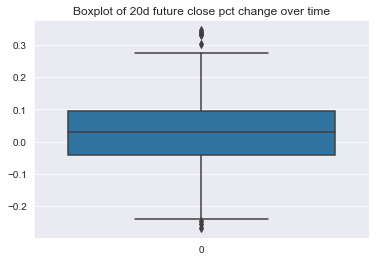

In [236]:
sns.set_style('darkgrid')
print(APPL['20d_future_close_pct'].describe())
bp = sns.boxplot(data = APPL['20d_future_close_pct'])
bp.set(title = 'Boxplot of 20d future close pct change over time')

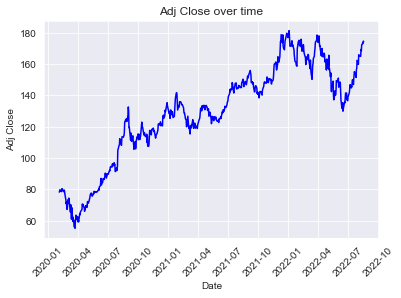

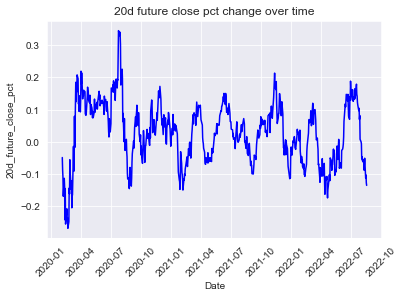

In [237]:
#Plot of prices and returns
priceplot = sns.lineplot(data=APPL['Adj Close'], color = 'blue')
priceplot.set(title = 'Adj Close over time')
plt.xticks(rotation = 45)
plt.show()
returnplot = sns.lineplot(data=APPL['20d_future_close_pct'], color = 'blue')
returnplot.set(title = '20d future close pct change over time')
plt.xticks(rotation = 45)
plt.show()

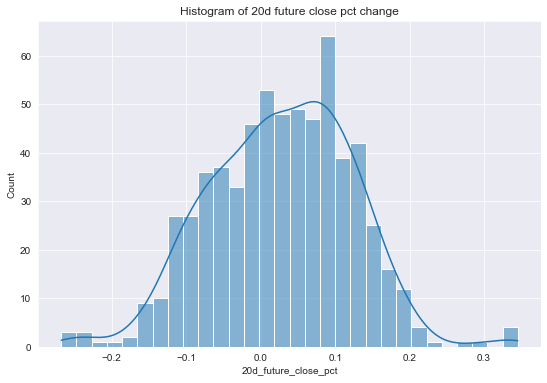

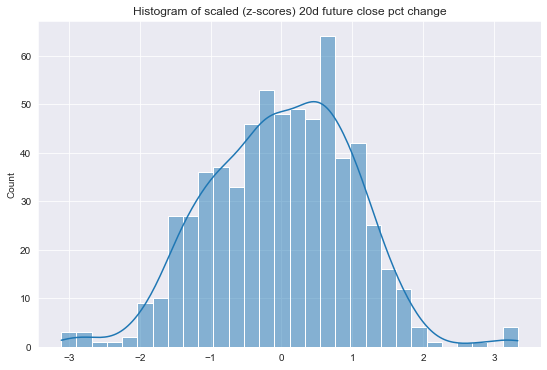

C:\Users\Cathal Keating\Anaconda3\Anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


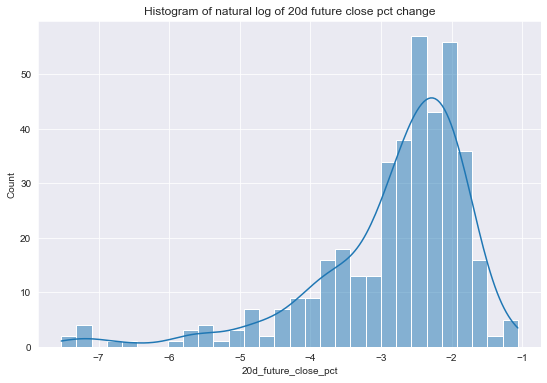

"\n#log returns scaled data\nsns.histplot(data = np.log(scaled['20d_future_close_pct_scaled'].values), bins = 30, kde = True)\nplt.show()\n"

In [238]:
#Looking at histograms
#no scaling
f, ax = plt.subplots(figsize=(9, 6))
plot1 = sns.histplot(data = APPL['20d_future_close_pct'], bins = 30, kde = True)
plot1.set(title = 'Histogram of 20d future close pct change')
plt.show()
#scaled
f, ax = plt.subplots(figsize=(9, 6))
scaled = pd.DataFrame()
scaled['20d_future_close_pct_scaled'] = ((APPL['20d_future_close_pct'] - 
                                          APPL['20d_future_close_pct'].mean())
                                         / APPL['20d_future_close_pct'].std())
plot2 = sns.histplot(data = scaled['20d_future_close_pct_scaled'].values, bins = 30, kde = True)
plot2.set(title = 'Histogram of scaled (z-scores) 20d future close pct change')
plt.show()
#Log returns
f, ax = plt.subplots(figsize=(9, 6))
plot3 = sns.histplot(data = np.log(APPL['20d_future_close_pct']), bins = 30, kde = True)
plot3.set(title = 'Histogram of natural log of 20d future close pct change')
plt.show()
'''
#log returns scaled data
sns.histplot(data = np.log(scaled['20d_future_close_pct_scaled'].values), bins = 30, kde = True)
plt.show()
'''

<ipython-input-239-e2b1a4fb5f30>:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  APPL[col].plot(fig = plt.figure(i))


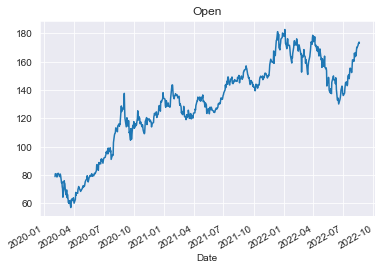

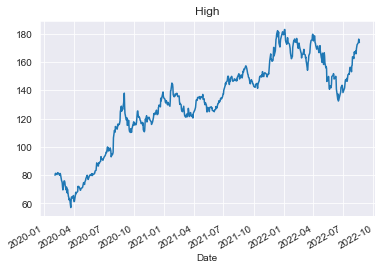

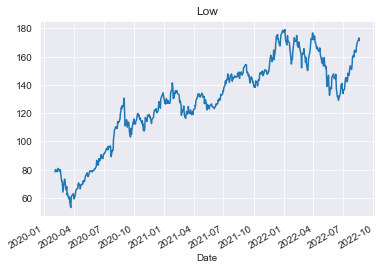

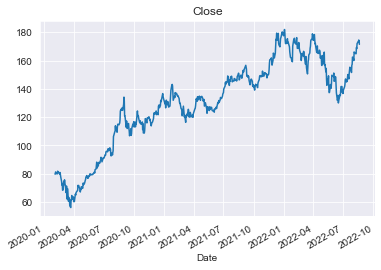

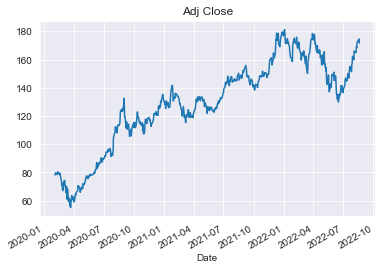

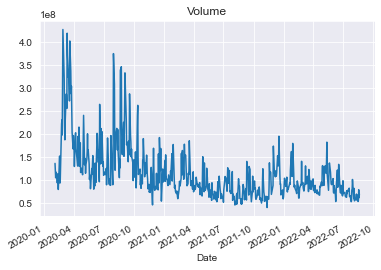

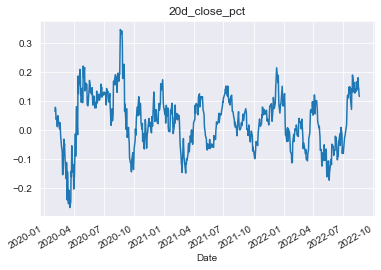

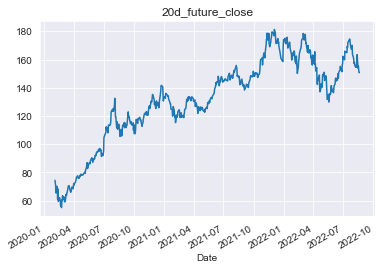

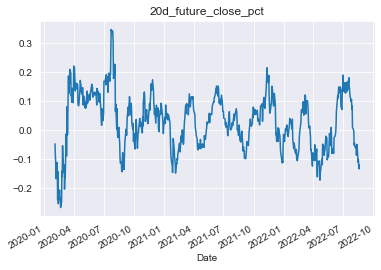

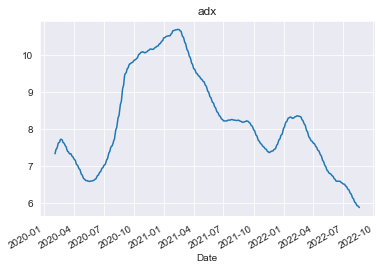

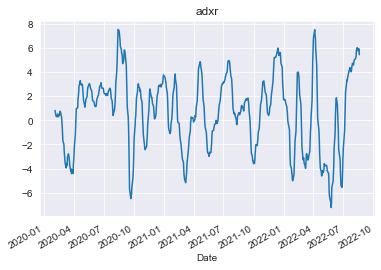

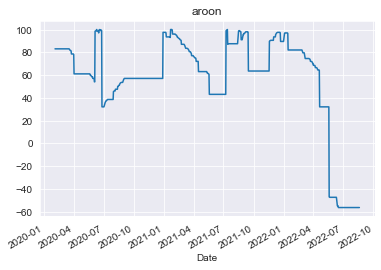

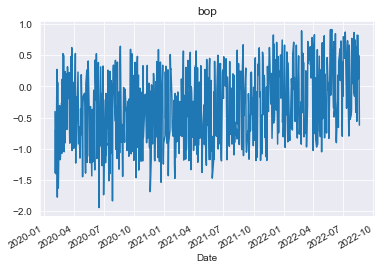

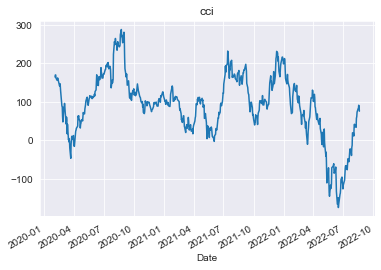

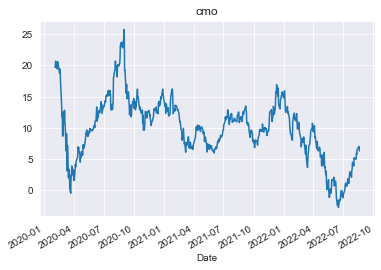

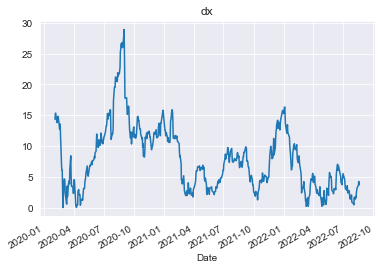

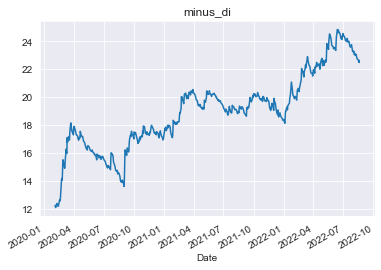

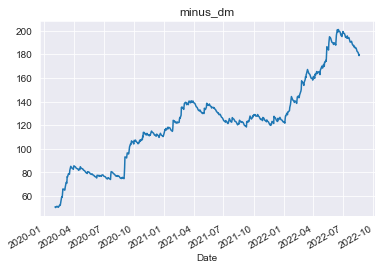

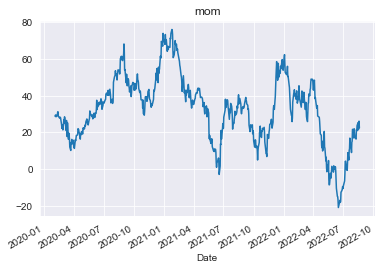

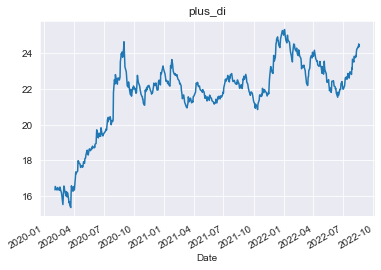

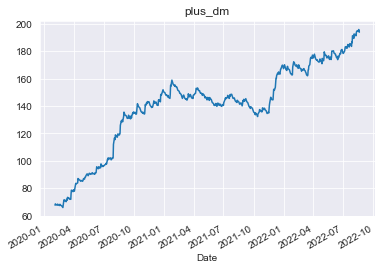

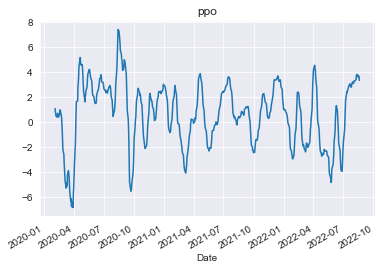

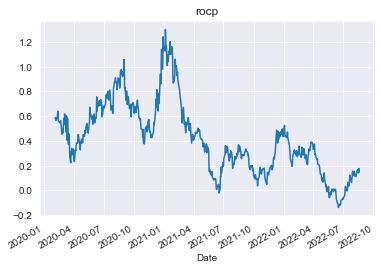

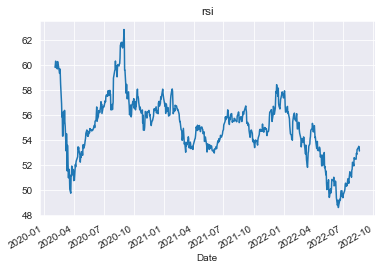

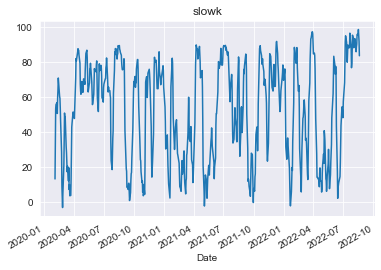

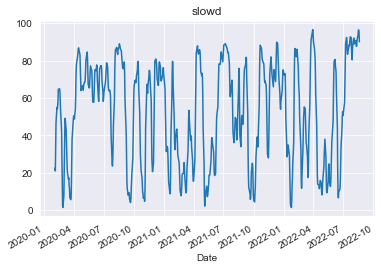

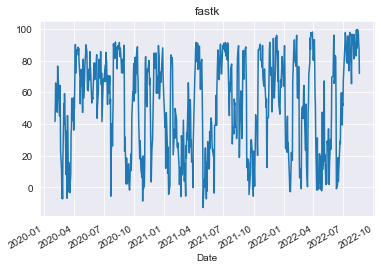

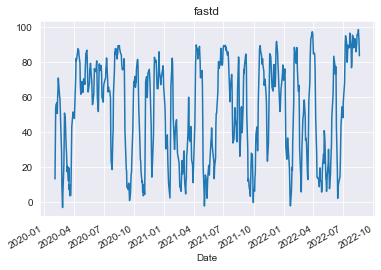

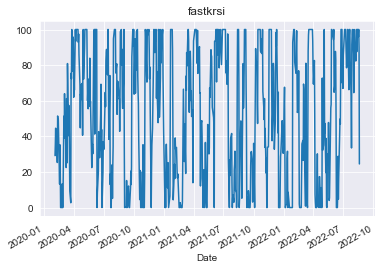

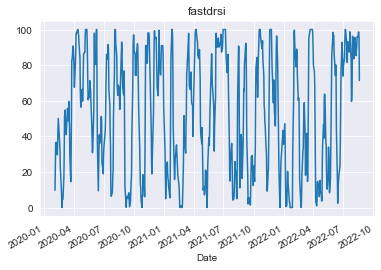

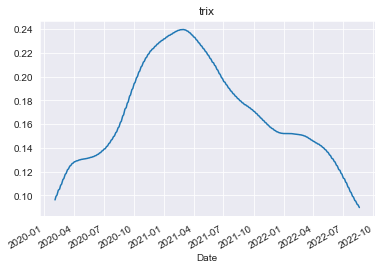

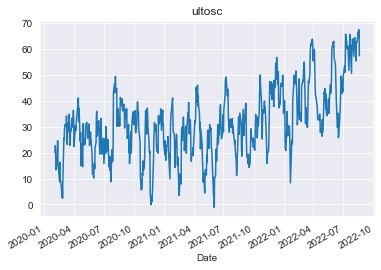

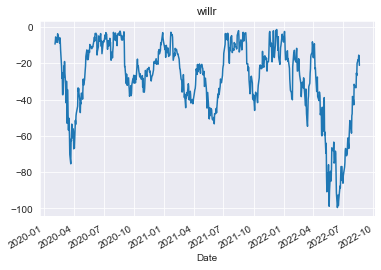

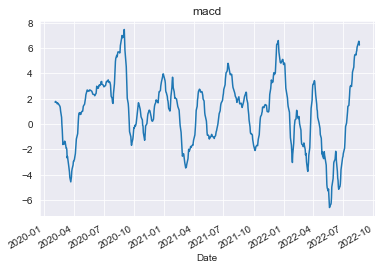

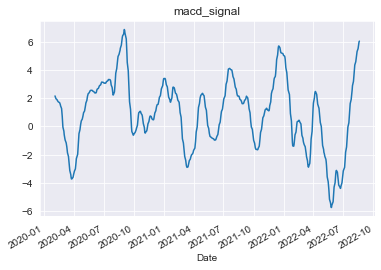

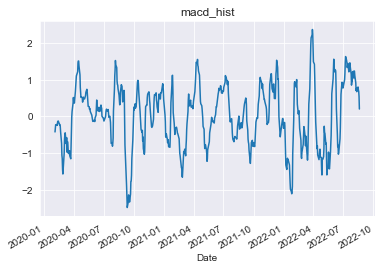

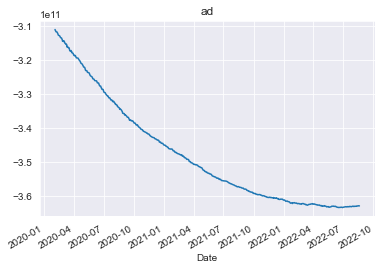

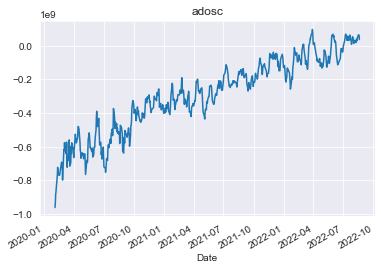

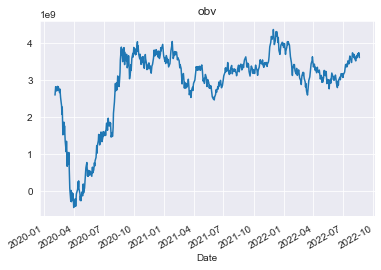

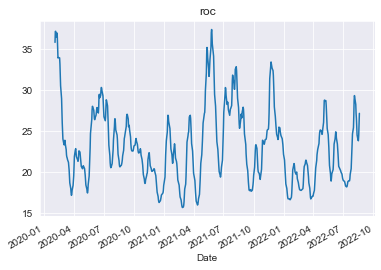

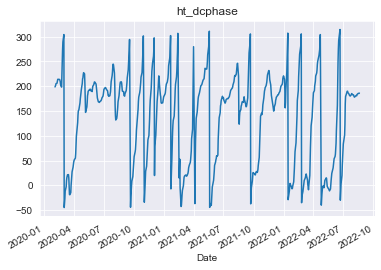

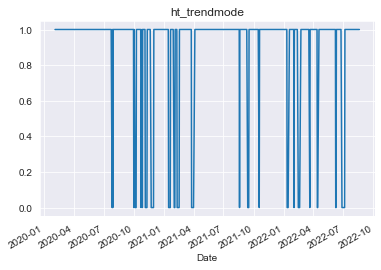

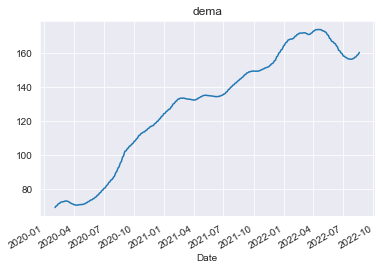

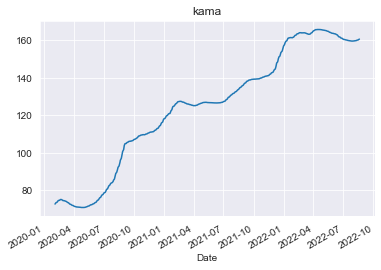

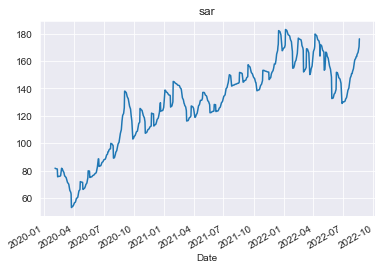

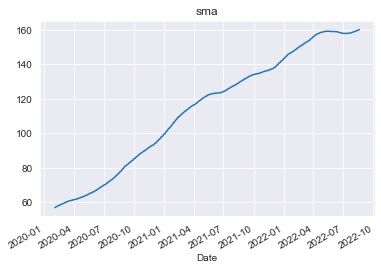

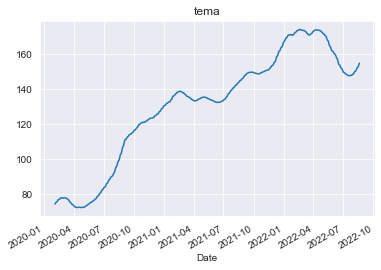

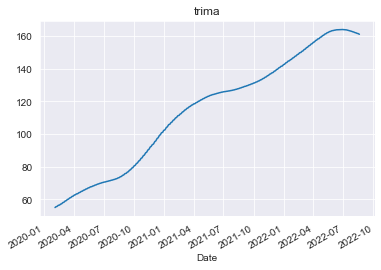

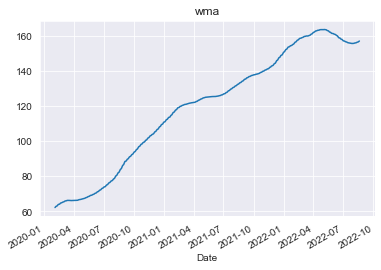

In [239]:
#print(APPL.head())
#print(APPL.columns)
#print(APPL.index)
#print(APPL['sar'].head())
#print(APPL['sar'].tail())
for i, col in enumerate(APPL.columns):
    APPL[col].plot(fig = plt.figure(i))
    plt.title(col)

plt.show()

In [240]:
#lets run a correlation

corr = APPL.corr()

print(corr)
APPL1 = APPL

                          Open      High       Low     Close  Adj Close  \
Open                  1.000000  0.999101  0.998820  0.997514   0.997447   
High                  0.999101  1.000000  0.998669  0.998793   0.998771   
Low                   0.998820  0.998669  1.000000  0.998849   0.998793   
Close                 0.997514  0.998793  0.998849  1.000000   0.999952   
Adj Close             0.997447  0.998771  0.998793  0.999952   1.000000   
Volume               -0.561944 -0.550075 -0.578237 -0.564867  -0.565315   
20d_close_pct         0.046625  0.043838  0.057080  0.055982   0.052659   
20d_future_close      0.928512  0.929578  0.931236  0.931087   0.931738   
20d_future_close_pct -0.335437 -0.336513 -0.332235 -0.336037  -0.334172   
adx                   0.033165  0.028916  0.027144  0.025830   0.018292   
adxr                  0.117956  0.111965  0.124310  0.118276   0.115424   
aroon                -0.105265 -0.109075 -0.107946 -0.110663  -0.116768   
bop                   0.2

20d_future_close_pct    1.00
obv                     0.42
Open                    0.34
Close                   0.34
High                    0.34
Low                     0.33
Adj Close               0.33
sar                     0.33
mom                     0.29
tema                    0.29
kama                    0.27
rsi                     0.27
cmo                     0.27
plus_di                 0.27
dema                    0.26
plus_dm                 0.24
wma                     0.23
sma                     0.21
willr                   0.20
cci                     0.19
trima                   0.19
macd_signal             0.19
adx                     0.17
adosc                   0.17
ultosc                  0.16
aroon                   0.16
macd                    0.15
dx                      0.15
ad                      0.15
rocp                    0.12
fastdrsi                0.12
minus_dm                0.10
fastkrsi                0.10
roc                     0.08
bop           

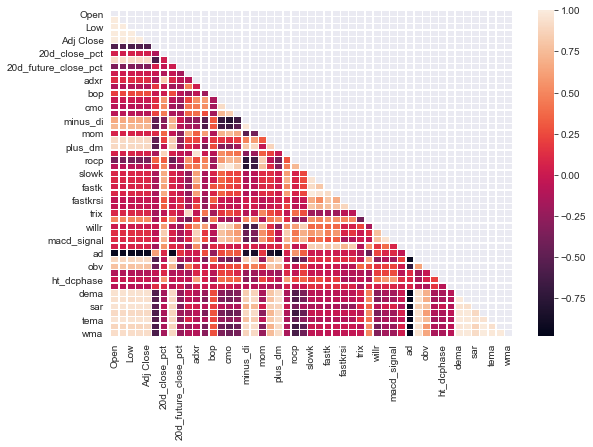

In [241]:
#Last look at correlations
corr = APPL.corr().round(decimals = 2)
f, ax = plt.subplots(figsize=(9, 6))
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, annot = False, ax = ax, linewidths=0.3, mask = mask)

#just used to order the correlatios
abscorrfuturepricechange = abs(corr)
abscorrfuturepricechange = abscorrfuturepricechange.sort_values(by = ['20d_future_close_pct'], 
                                                                ascending = False)
print(abscorrfuturepricechange['20d_future_close_pct'])
#print(20d_future_close_pct_corr.sort

In [340]:
#Function  to generate plots:
    
def GeneratePlots(plotvariables, df):
    '''
    for a given list of indicator this generates 3 plots:
    1. line plot of 20 day future close price change vs indicator supplied
    2. line plot of adj close vs indicator supplied
    3. scatter plot of 20 day future close price change vs indicator supplied
    
    need to input:
    1.list of indicator names
    2.dataframe
    
    
    '''
    for var in plotvariables:
        #return overlay indicator
        f, ax = plt.subplots(figsize=(9, 6))
        plot1 = sns.lineplot(data=df['20d_future_close_pct'], color = 'blue', 
                             label = '20d_future_close_pct')
        ax2 = ax.twinx()
        sns.lineplot(data=df[var], color = 'red', label = var)
        plot1.set(title = '20d_future_close_pct vs ' + var)
        plt.xticks(rotation = 45)
        plt.legend()
        plt.show()

        #price overlay indicator
        f, ax = plt.subplots(figsize=(9, 6))
        plot1 = sns.lineplot(data=df['Adj Close'], color = 'blue', 
                             label = '20d_future_close_pct')
        ax2 = ax.twinx()
        sns.lineplot(data=df[var], color = 'red', label = var)
        plot1.set(title = 'Adj Close vs ' + var)
        plt.xticks(rotation = 45)
        plt.legend()
        plt.show()

        #Scatter reurn vs indicator
        f, ax = plt.subplots(figsize=(9, 6))
        plot1 = sns.scatterplot(df['20d_future_close_pct'], df[var], color = 'blue')
        #ax2 = ax.twinx()
        #sns.lineplot(data=APPL1['mom'], color = 'red')
        plot1.set(title = '20d_future_close_pct vs ' + var)
        plt.xticks(rotation = 45)

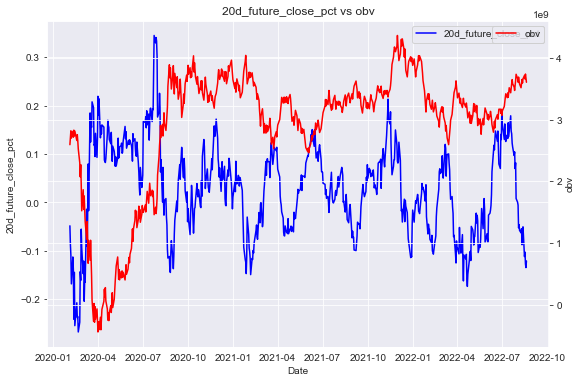

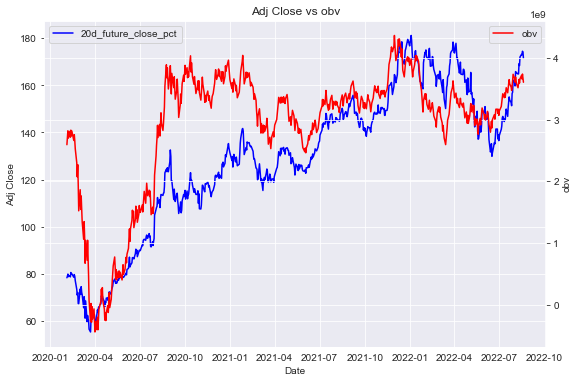

C:\Users\Cathal Keating\Anaconda3\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


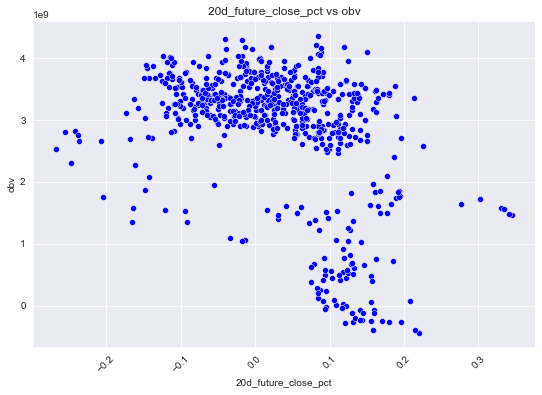

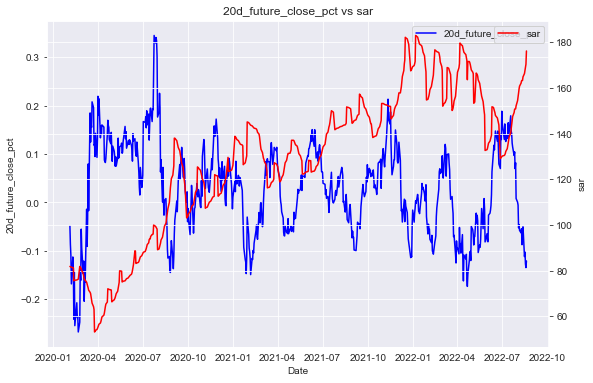

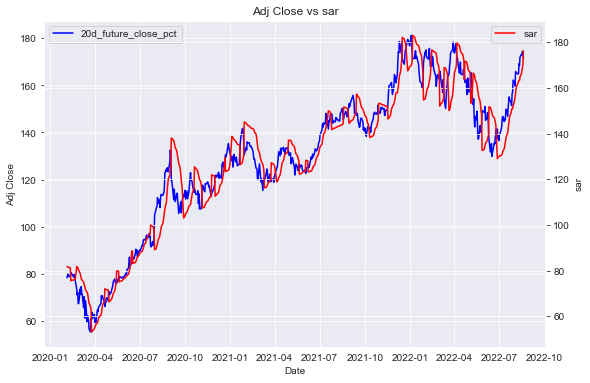

C:\Users\Cathal Keating\Anaconda3\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


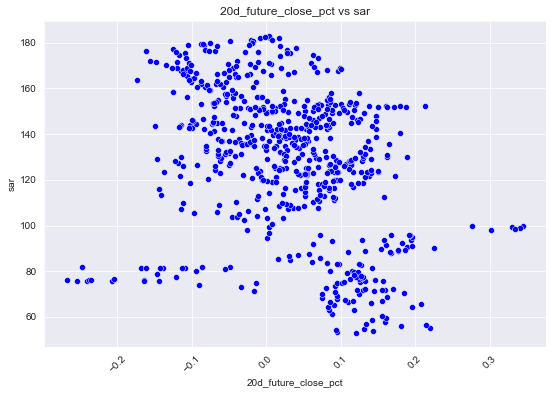

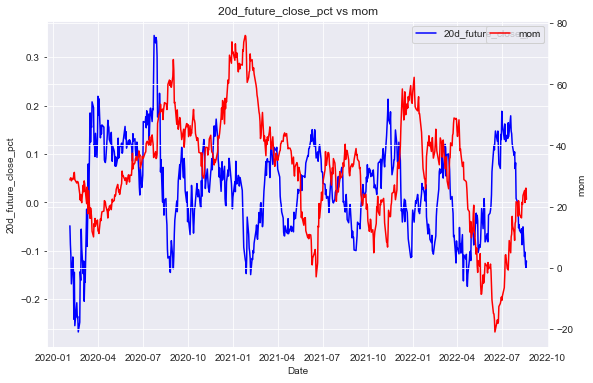

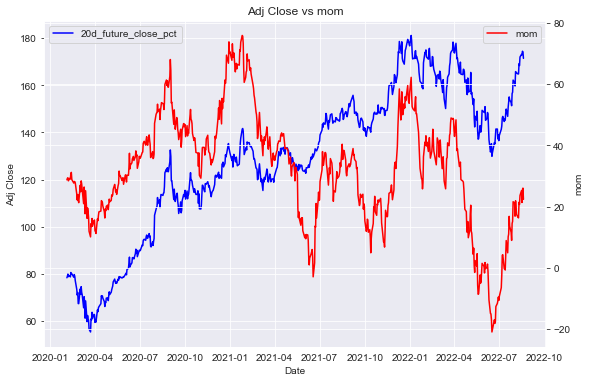

C:\Users\Cathal Keating\Anaconda3\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


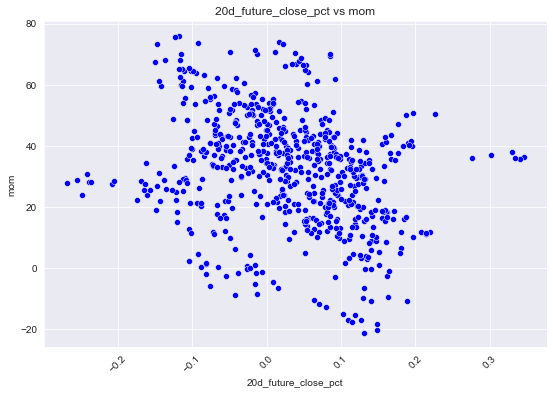

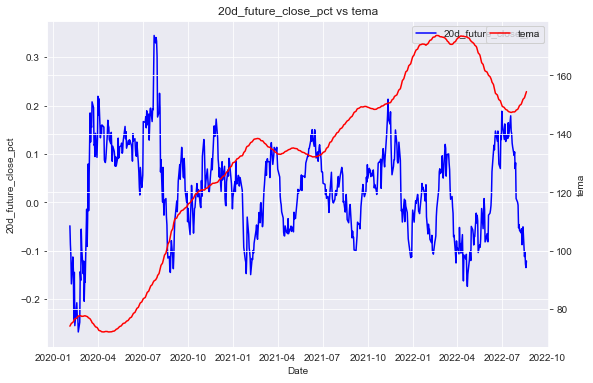

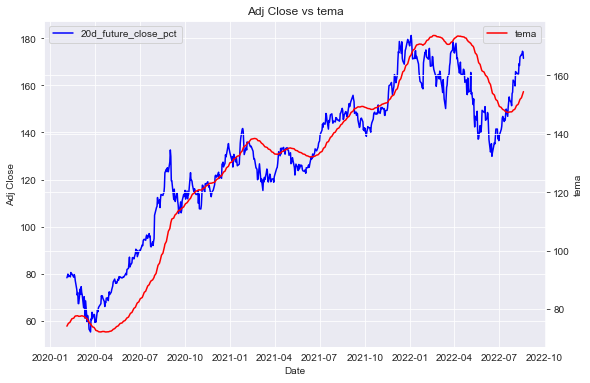

C:\Users\Cathal Keating\Anaconda3\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


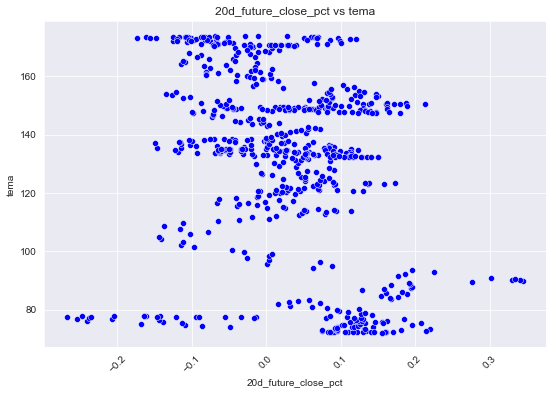

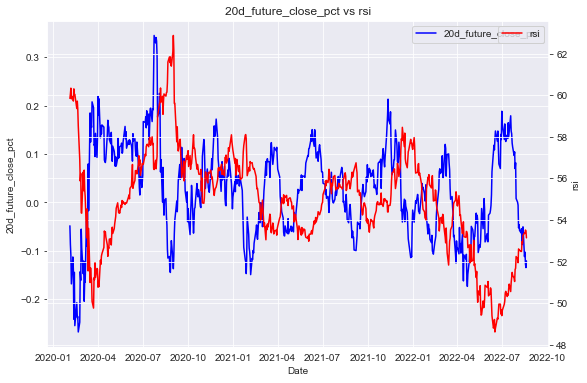

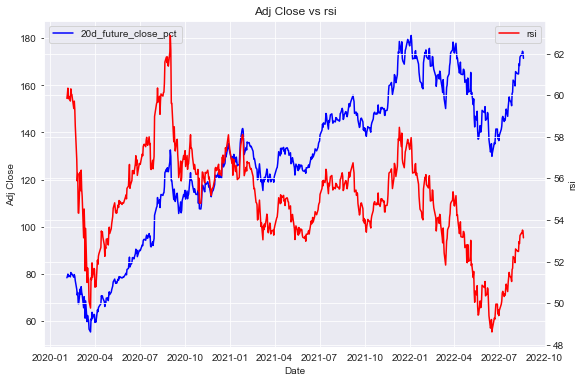

C:\Users\Cathal Keating\Anaconda3\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


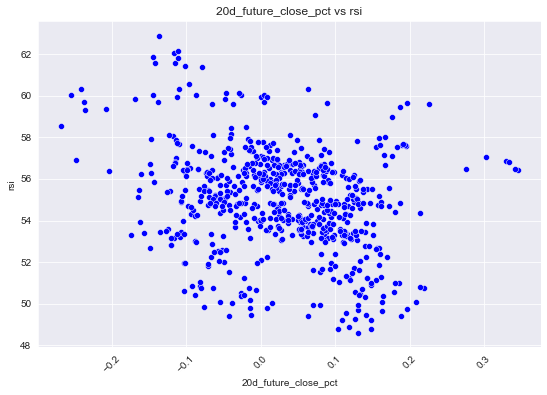

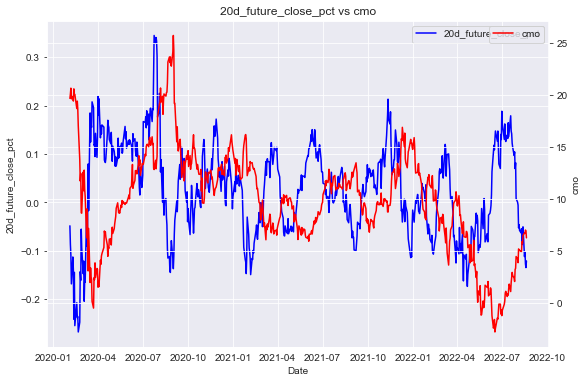

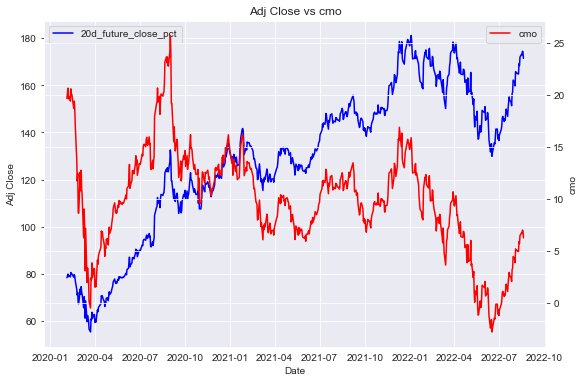

C:\Users\Cathal Keating\Anaconda3\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


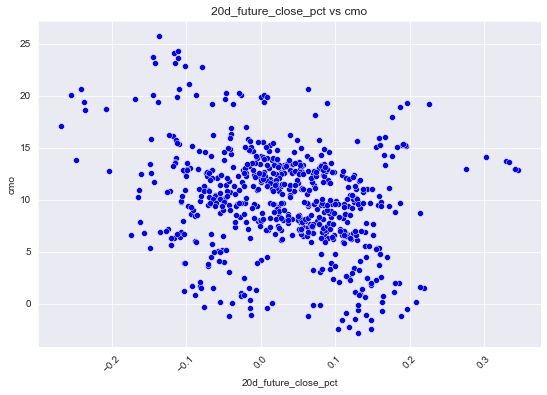

In [341]:
plotvariables = ['obv', 'sar', 'mom', 'tema', 'rsi', 'cmo']
GeneratePlots(plotvariables, APPL1)

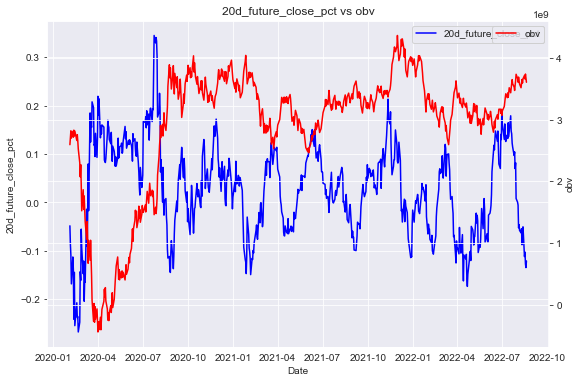

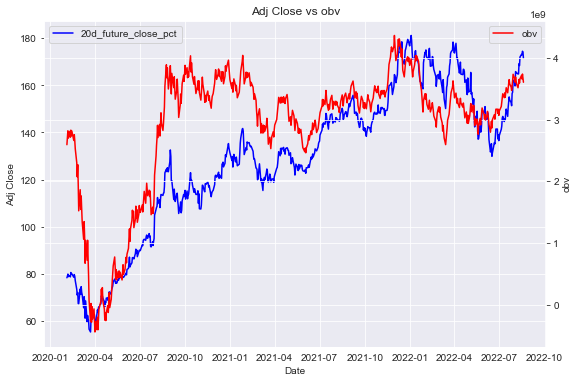

C:\Users\Cathal Keating\Anaconda3\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


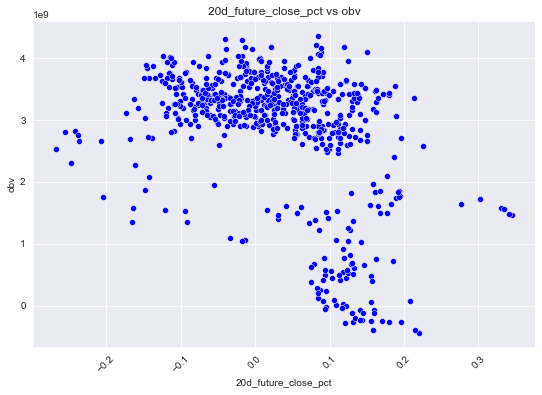

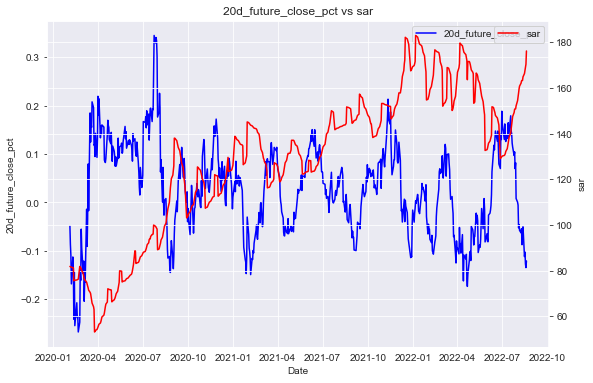

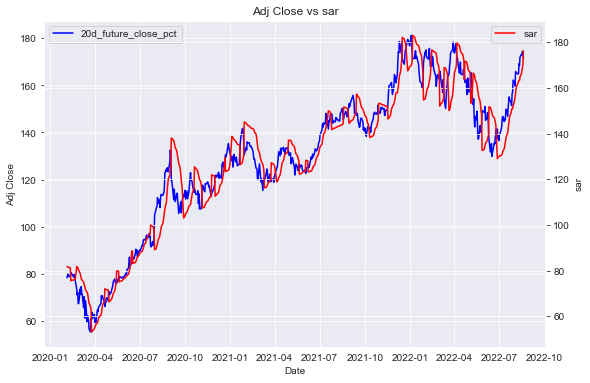

C:\Users\Cathal Keating\Anaconda3\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


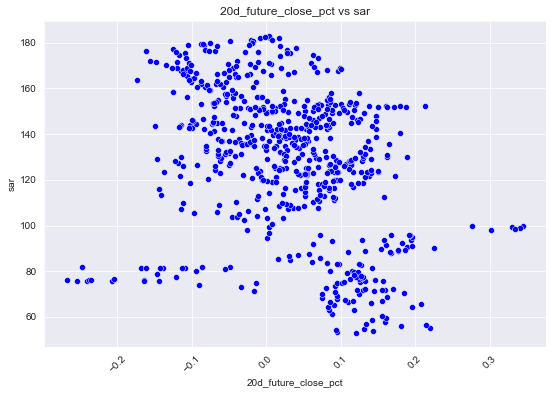

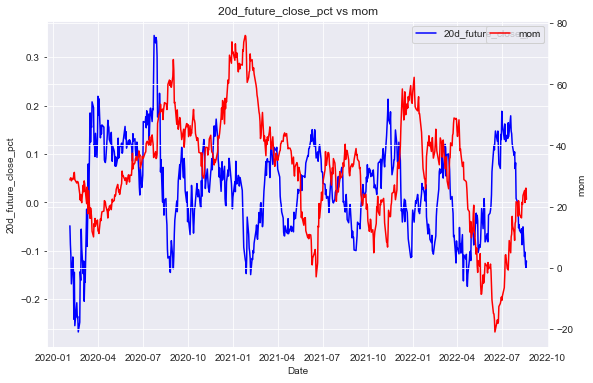

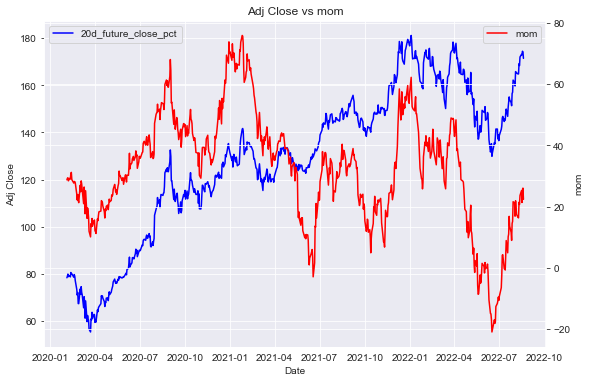

C:\Users\Cathal Keating\Anaconda3\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


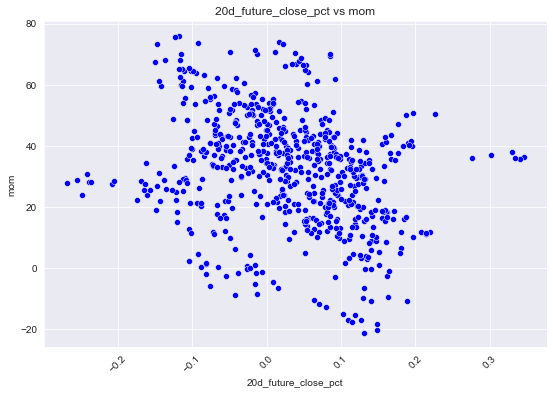

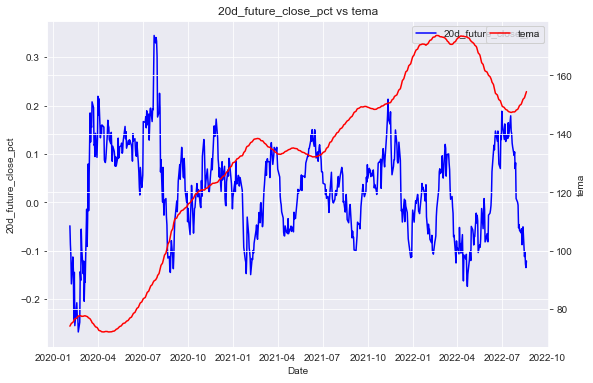

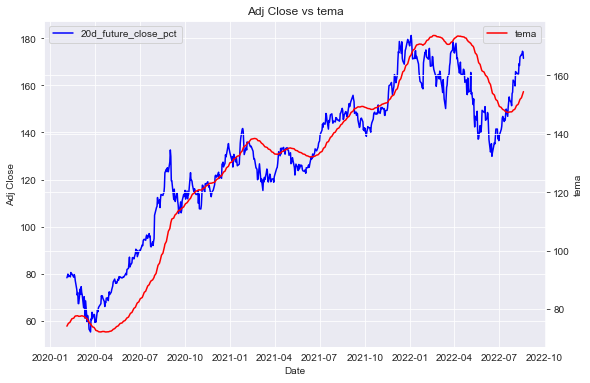

C:\Users\Cathal Keating\Anaconda3\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


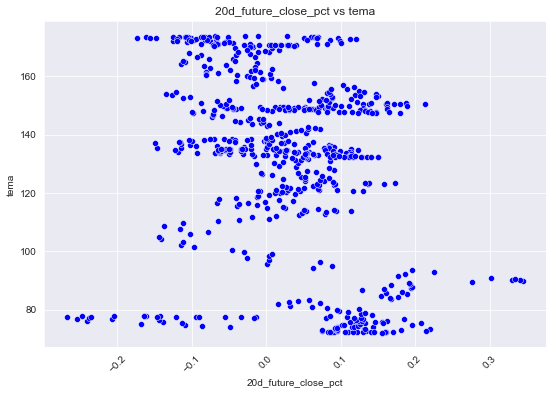

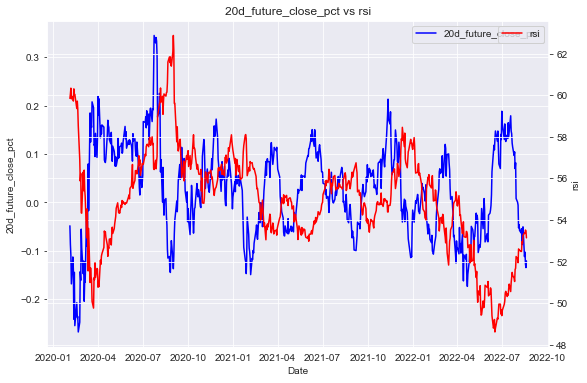

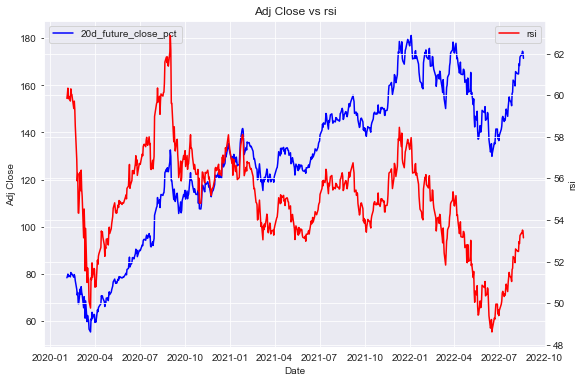

C:\Users\Cathal Keating\Anaconda3\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


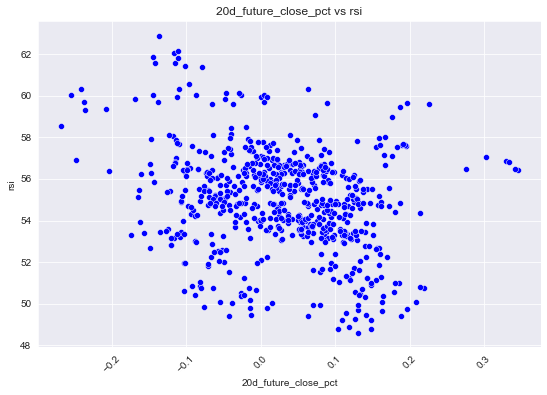

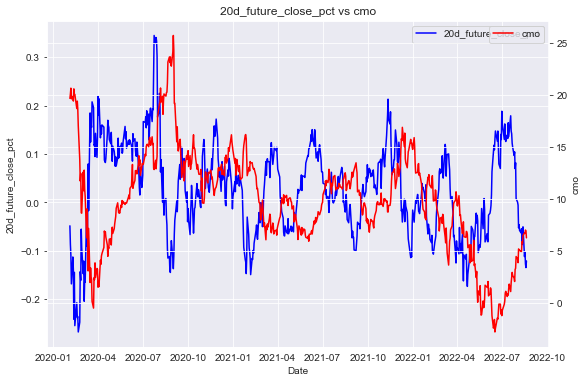

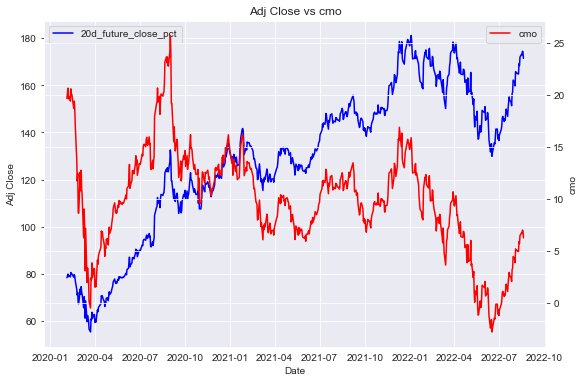

C:\Users\Cathal Keating\Anaconda3\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


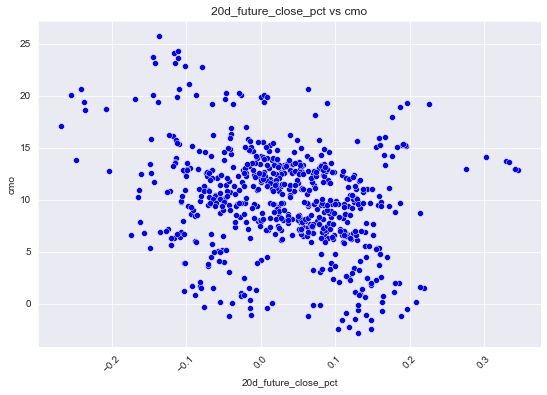

In [242]:
#graph the prices:
#I picked some of the more correlated variables

plotvariables = ['obv', 'sar', 'mom', 'tema', 'rsi', 'cmo']

for var in plotvariables:
    #return overlay indicator
    f, ax = plt.subplots(figsize=(9, 6))
    plot1 = sns.lineplot(data=APPL1['20d_future_close_pct'], color = 'blue', 
                         label = '20d_future_close_pct')
    ax2 = ax.twinx()
    sns.lineplot(data=APPL1[var], color = 'red', label = var)
    plot1.set(title = '20d_future_close_pct vs ' + var)
    plt.xticks(rotation = 45)
    plt.legend()
    plt.show()
    #ax.set_xlabel('Time')
    
    #price overlay indicator
    f, ax = plt.subplots(figsize=(9, 6))
    plot1 = sns.lineplot(data=APPL1['Adj Close'], color = 'blue', 
                         label = '20d_future_close_pct')
    ax2 = ax.twinx()
    sns.lineplot(data=APPL1[var], color = 'red', label = var)
    plot1.set(title = 'Adj Close vs ' + var)
    plt.xticks(rotation = 45)
    plt.legend()
    plt.show()

    #Scatter reurn vs indicator
    f, ax = plt.subplots(figsize=(9, 6))
    plot1 = sns.scatterplot(APPL1['20d_future_close_pct'], APPL1[var], color = 'blue')
    #ax2 = ax.twinx()
    #sns.lineplot(data=APPL1['mom'], color = 'red')
    plot1.set(title = '20d_future_close_pct vs ' + var)
    plt.xticks(rotation = 45)



Prepping data sets for machine learning

In [243]:
#Lets set up the recordsets for regression
#We need the following:
#Our independent variables or features
independent_variables = APPL1.drop(['20d_future_close_pct'], axis = 1)
independent_variables_names = independent_variables.columns.values.tolist()
print(independent_variables_names)
#Our dependent variables or targets
dependent_variable_name = ['20d_future_close_pct']
dependent_variable = APPL1[dependent_variable_name]

print(dependent_variable.columns)

['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', '20d_close_pct', '20d_future_close', 'adx', 'adxr', 'aroon', 'bop', 'cci', 'cmo', 'dx', 'minus_di', 'minus_dm', 'mom', 'plus_di', 'plus_dm', 'ppo', 'rocp', 'rsi', 'slowk', 'slowd', 'fastk', 'fastd', 'fastkrsi', 'fastdrsi', 'trix', 'ultosc', 'willr', 'macd', 'macd_signal', 'macd_hist', 'ad', 'adosc', 'obv', 'roc', 'ht_dcphase', 'ht_trendmode', 'dema', 'kama', 'sar', 'sma', 'tema', 'trima', 'wma']
Index(['20d_future_close_pct'], dtype='object')


In [244]:
#Preparing the recordsets for linear and logistic regression
#As it is time series data I cannot use a simple train_test_split
#Have to order the data - 75% of the earliest data is the train set
#25% the most recent data is the test
regression_independent_variables = sm.add_constant(independent_variables)
train_size = int(0.75*dependent_variable.shape[0])
train_regression_independent_variables = regression_independent_variables[:train_size]
train_regression_dependent_variables = dependent_variable[:train_size]
test_regression_independent_variables = regression_independent_variables[train_size:]
test_regression_dependent_variables = dependent_variable[train_size:]

In [245]:
#Quick check to make sure data looks ok:
print(train_regression_independent_variables.isnull().sum())
print(train_regression_dependent_variables.isnull().sum())
#Looks good

const               0
Open                0
High                0
Low                 0
Close               0
Adj Close           0
Volume              0
20d_close_pct       0
20d_future_close    0
adx                 0
adxr                0
aroon               0
bop                 0
cci                 0
cmo                 0
dx                  0
minus_di            0
minus_dm            0
mom                 0
plus_di             0
plus_dm             0
ppo                 0
rocp                0
rsi                 0
slowk               0
slowd               0
fastk               0
fastd               0
fastkrsi            0
fastdrsi            0
trix                0
ultosc              0
willr               0
macd                0
macd_signal         0
macd_hist           0
ad                  0
adosc               0
obv                 0
roc                 0
ht_dcphase          0
ht_trendmode        0
dema                0
kama                0
sar                 0
sma       

Model 1 Linear Model

In [246]:
#Fit the Linear model
linear_model = sm.OLS(train_regression_dependent_variables, train_regression_independent_variables)
linear_model_results = linear_model.fit()

#Lets have a look at the summary output:
print(linear_model_results.summary())

                             OLS Regression Results                             
Dep. Variable:     20d_future_close_pct   R-squared:                       0.989
Model:                              OLS   Adj. R-squared:                  0.988
Method:                   Least Squares   F-statistic:                     923.1
Date:                  Mon, 19 Sep 2022   Prob (F-statistic):               0.00
Time:                          15:24:19   Log-Likelihood:                 1543.2
No. Observations:                   481   AIC:                            -2996.
Df Residuals:                       436   BIC:                            -2808.
Df Model:                            44                                         
Covariance Type:              nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               

Index(['Low', 'Close', 'Adj Close', 'Volume', '20d_close_pct',
       '20d_future_close', 'adx', 'adxr', 'cmo', 'dx', 'mom', 'ppo', 'rocp',
       'rsi', 'macd_signal', 'ad', 'obv', 'roc', 'ht_dcphase', 'sar', 'sma',
       'tema', 'trima', 'wma', 'negative_positive_20d_return'],
      dtype='object')
model1 linear regression score (training data) (insignificant variables dropped): 
0.9888384799552805
model1 linear regression score (test data) (insignificant variables dropped): 
0.7478303199533388


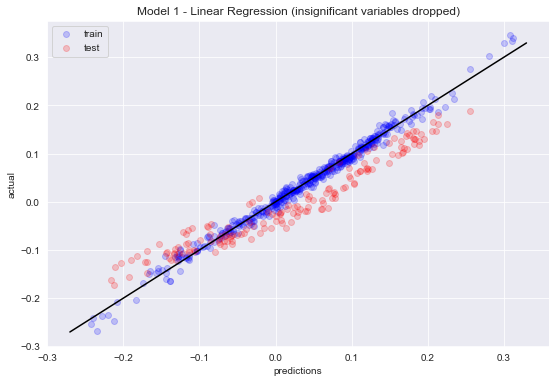

In [304]:
#Reapplying the linear regression
#Going to use this to streamline the record set
#Anything with a P Value greater than 0.05 remove

#picking out variables that have P-Valeus greater than 0.05
dropvariables = linear_model_results.pvalues[abs(linear_model_results.pvalues) > 0.05]
to_drop = dropvariables.index.tolist()
#Checking the variables
#print(to_drop)

#rerunning the old sets
independent_variables = APPL1.drop(['20d_future_close_pct'], axis = 1)
independent_variables_names = independent_variables.columns.values.tolist()

#Our dependent variables or targets
dependent_variable_name = ['20d_future_close_pct']
dependent_variable = APPL1[dependent_variable_name]

#new set with the dropped variables
cleaned_independent_variables = independent_variables.drop(independent_variables[to_drop], axis = 1)
print(cleaned_independent_variables.columns)
#Linear regression scikit learn:
#With new record set

regression_independent_variables = independent_variables
train_size = int(0.75*dependent_variable.shape[0])
train_regression_independent_variables = cleaned_independent_variables[:train_size]
train_regression_dependent_variables = dependent_variable[:train_size]
test_regression_independent_variables = cleaned_independent_variables[train_size:]
test_regression_dependent_variables = dependent_variable[train_size:]

#print(train_regression_independent_variables.columns)


#Fit the model
#Call the package
from sklearn.linear_model import LinearRegression
#Setting the model
linregclean = LinearRegression()
#Fit to the data
linregclean.fit(train_regression_independent_variables, train_regression_dependent_variables)
#make our predictions on our train and test set
train_linregclean_pred = linregclean.predict(train_regression_independent_variables)
test_linregclean_pred = linregclean.predict(test_regression_independent_variables)
#Check the scores of the train and test model

train_linregclean_score = linregclean.score(train_regression_independent_variables, 
                                  train_regression_dependent_variables)
test_linregclean_score = linregclean.score(test_regression_independent_variables, 
                                  test_regression_dependent_variables)

print("model1 linear regression score (training data) (insignificant variables dropped): \n" 
      + str(train_linregclean_score))
print("model1 linear regression score (test data) (insignificant variables dropped): \n" 
      + str(test_linregclean_score))

#Finally plot the data
f, ax = plt.subplots(figsize=(9, 6))
plt.scatter(train_linregclean_pred, train_regression_dependent_variables,
            alpha=0.2, color='b', label='train')

plt.scatter(test_linregclean_pred, test_regression_dependent_variables, 
            alpha=0.2, color='r', label='test')

plt.title('Model 1 - Linear Regression (insignificant variables dropped)')
xmin, xmax = plt.xlim()
plt.plot(np.arange(xmin, xmax, 0.01), np.arange(xmin, xmax, 0.01), c='k')

plt.xlabel('predictions')
plt.ylabel('actual')
plt.legend()  # show the legend

plt.show()

Model 1.1 Ridge Linear Regression

C:\Users\Cathal Keating\Anaconda3\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=7.62842e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


model 1.1 ridge linear regression score (training data): 
0.9887924002908643
model 1.1 ridge linear regression score (test data): 
0.7499444697060915


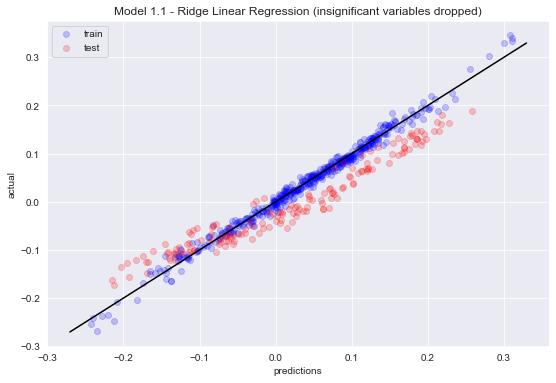

In [306]:
#Ridge Linear regression scikit learn:
#I don't think we need the constant any more so going to re run the datasets
#Ridge you penalise the bigger predictins

regression_independent_variables = independent_variables
train_size = int(0.75*dependent_variable.shape[0])
train_regression_independent_variables = cleaned_independent_variables[:train_size]
train_regression_dependent_variables = dependent_variable[:train_size]
test_regression_independent_variables = cleaned_independent_variables[train_size:]
test_regression_dependent_variables = dependent_variable[train_size:]

#Fit the model
#Call the package
from sklearn.linear_model import Ridge
#Setting the model
ridgereg = Ridge(alpha = 0.1)
#Fit to the data
ridgereg.fit(train_regression_independent_variables, train_regression_dependent_variables)
#make our predictions on our train and test set
train_ridgereg_pred = ridgereg.predict(train_regression_independent_variables)
test_ridgereg_pred = ridgereg.predict(test_regression_independent_variables)
#Check the scores of the train and test model

train_ridgereg_score = ridgereg.score(train_regression_independent_variables, 
                                  train_regression_dependent_variables)
test_ridgereg_score = ridgereg.score(test_regression_independent_variables, 
                                  test_regression_dependent_variables)

print("model 1.1 ridge linear regression score (training data): \n" + str(train_ridgereg_score))
print("model 1.1 ridge linear regression score (test data): \n" + str(test_ridgereg_score))

#Finally plot the data
f, ax = plt.subplots(figsize=(9, 6))
plt.scatter(train_ridgereg_pred, train_regression_dependent_variables,
            alpha=0.2, color='b', label='train')

plt.scatter(test_ridgereg_pred, test_regression_dependent_variables, 
            alpha=0.2, color='r', label='test')

xmin, xmax = plt.xlim()
plt.plot(np.arange(xmin, xmax, 0.01), np.arange(xmin, xmax, 0.01), c='k')
plt.title('Model 1.1 - Ridge Linear Regression (insignificant variables dropped)')
plt.xlabel('predictions')
plt.ylabel('actual')
plt.legend()  # show the legend

plt.show()

Hyperparameter tuning

In [249]:
#Setting the dataset

regression_independent_variables = independent_variables
train_size = int(0.75*dependent_variable.shape[0])
train_regression_independent_variables = cleaned_independent_variables[:train_size]
train_regression_dependent_variables = dependent_variable[:train_size]
test_regression_independent_variables = cleaned_independent_variables[train_size:]
test_regression_dependent_variables = dependent_variable[train_size:]

#Fit the model
#Call the package
from sklearn.linear_model import Ridge
#list to store our scores:
scoresridge = []
for alpha in [0.1, 1, 10, 100, 1000, 10000, 100000]:
    tuneridgereg = Ridge(alpha = alpha)
    tuneridgereg.fit(train_regression_independent_variables, train_regression_dependent_variables)
    tuneridgereg_pred = tuneridgereg.predict(test_regression_independent_variables)
    scoresridge.append(tuneridgereg.score(test_regression_independent_variables, 
                                    test_regression_dependent_variables))

print(scoresridge)

#Find a way to plot these

[0.7717889330018499, 0.7706086006347974, 0.7817590463122019, 0.8727546962748869, 0.8569445219141935, 0.8651913077546309, 0.43397866384256234]


C:\Users\Cathal Keating\Anaconda3\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=7.62882e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\Cathal Keating\Anaconda3\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=7.52441e-24): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\Cathal Keating\Anaconda3\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=7.2181e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\Cathal Keating\Anaconda3\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=8.491e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\

Model 1.2 Lasso Linear Regression

C:\Users\Cathal Keating\Anaconda3\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.361e-02, tolerance: 4.333e-04
  model = cd_fast.enet_coordinate_descent(
C:\Users\Cathal Keating\Anaconda3\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.781e-01, tolerance: 1.025e-02
  model = cd_fast.enet_coordinate_descent(


model 1.2 lasso linear regression score (training data): 
0.9913014765517013
model 1.2 lasso linear regression score (test data): 
0.9326707500352811


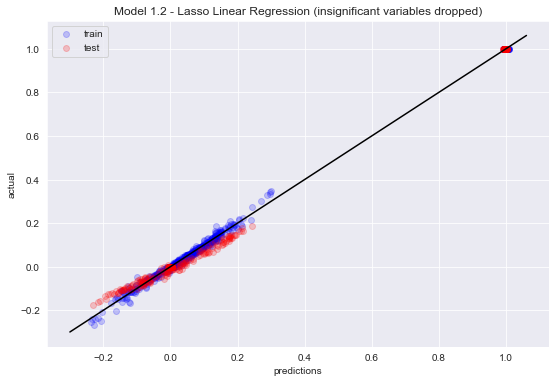

In [323]:
#Lasso Linear regression scikit learn:
#I don't think we need the constant any more so going to re run the datasets
#Lasso you penalise the bigger predictins

regression_independent_variables = independent_variables
train_size = int(0.75*dependent_variable.shape[0])
train_regression_independent_variables = cleaned_independent_variables[:train_size]
train_regression_dependent_variables = dependent_variable[:train_size]
test_regression_independent_variables = cleaned_independent_variables[train_size:]
test_regression_dependent_variables = dependent_variable[train_size:]

#Fit the model
#Call the package
from sklearn.linear_model import Lasso
#Setting the model
lassoreg = Lasso(alpha = 0.001)
#Fit to the data
lassoreg.fit(train_regression_independent_variables, train_regression_dependent_variables)
#make our predictions on our train and test set
train_lassoreg_pred = lassoreg.predict(train_regression_independent_variables)
test_lassoreg_pred = lassoreg.predict(test_regression_independent_variables)
#Check the scores of the train and test model

train_lassoreg_score = lassoreg.score(train_regression_independent_variables, 
                                  train_regression_dependent_variables)
test_lassoreg_score = lassoreg.score(test_regression_independent_variables, 
                                  test_regression_dependent_variables)

print("model 1.2 lasso linear regression score (training data): \n" + str(train_lassoreg_score))
print("model 1.2 lasso linear regression score (test data): \n" + str(test_lassoreg_score))

#Finally plot the data
f, ax = plt.subplots(figsize=(9, 6))
plt.scatter(train_lassoreg_pred, train_regression_dependent_variables,
            alpha=0.2, color='b', label='train')

plt.scatter(test_lassoreg_pred, test_regression_dependent_variables, 
            alpha=0.2, color='r', label='test')

xmin, xmax = plt.xlim()
plt.plot(np.arange(xmin, xmax, 0.01), np.arange(xmin, xmax, 0.01), c='k')
plt.title('Model 1.2 - Lasso Linear Regression (insignificant variables dropped)')
plt.xlabel('predictions')
plt.ylabel('actual')
plt.legend()  # show the legend

plt.show()

Hyperparameter tuning

In [324]:
#Lasso Linear regression scikit learn:
#I don't think we need the constant any more so going to re run the datasets
#Lasso you penalise the bigger predictins

regression_independent_variables = independent_variables
train_size = int(0.75*dependent_variable.shape[0])
train_regression_independent_variables = cleaned_independent_variables[:train_size]
train_regression_dependent_variables = dependent_variable[:train_size]
test_regression_independent_variables = cleaned_independent_variables[train_size:]
test_regression_dependent_variables = dependent_variable[train_size:]

#Fit the model
#Call the package
from sklearn.linear_model import Lasso
#list to store our scores:
lassoscores = []
for alpha in np.linspace(0.001, 0.06, 10):
    tunelassoreg = Lasso(alpha = alpha)
    tunelassoreg.fit(train_regression_independent_variables, train_regression_dependent_variables)
    tunelassoreg_pred = tunelassoreg.predict(test_regression_independent_variables)
    lassoscores.append((alpha, tunelassoreg.score(test_regression_independent_variables, 
                                    test_regression_dependent_variables)))

print(lassoscores)
#best alpha is 0.112

C:\Users\Cathal Keating\Anaconda3\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.361e-02, tolerance: 4.333e-04
  model = cd_fast.enet_coordinate_descent(
C:\Users\Cathal Keating\Anaconda3\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.781e-01, tolerance: 1.025e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\Cathal Keating\Anaconda3\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider in

[(0.001, 0.9326707500352811), (0.007555555555555555, 0.9091874976149308), (0.014111111111111109, 0.9111954446302588), (0.020666666666666667, 0.91769055677853), (0.02722222222222222, 0.9221888693548792), (0.033777777777777775, 0.9224556719066307), (0.04033333333333333, 0.9187623134185572), (0.04688888888888888, 0.9088410476832443), (0.05344444444444444, 0.8933550819721116), (0.06, 0.8732158156557251)]


C:\Users\Cathal Keating\Anaconda3\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.833e-01, tolerance: 4.333e-04
  model = cd_fast.enet_coordinate_descent(
C:\Users\Cathal Keating\Anaconda3\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.743e+01, tolerance: 1.025e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\Cathal Keating\Anaconda3\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider in

Feature Selection

In [327]:
#Feel the model is over complicated (too manny variables)
#going to use lasso with alpha = 0.112 to access feature selection

regression_independent_variables = independent_variables
train_size = int(0.75*dependent_variable.shape[0])
train_regression_independent_variables = cleaned_independent_variables[:train_size]
train_regression_dependent_variables = dependent_variable[:train_size]
test_regression_independent_variables = cleaned_independent_variables[train_size:]
test_regression_dependent_variables = dependent_variable[train_size:]

#Fit the model
#Call the package
from sklearn.linear_model import Lasso
#Setting the model
lassoreg = Lasso(alpha = 0.001)
#lassoreg = Lasso(alpha = 0.05344444444444444)
#Fit to the data
lassoreg.fit(train_regression_independent_variables, train_regression_dependent_variables)

#Pull out the coeficents
lassoreg_coef = abs(lassoreg.coef_)
#print(train_regression_independent_variables.columns)
#print(lassoreg_coef)

feature_dict = dict(zip(train_regression_independent_variables.columns, 
                       lassoreg_coef))

feature_df = pd.DataFrame()
feature_df = pd.DataFrame.from_dict(feature_dict, orient = 'index')
feature_df.columns = ['coefficent']
#print(feature_df)
#print(feature_df.index)
feature_df.sort_values(by = ['coefficent'], inplace = True,  ascending = False)
print(feature_df)


f, ax = plt.subplots(figsize=(9, 6))
plt.bar(feature_df.index, feature_df['coefficent'])
plt.xticks(rotation = 90)
plt.title('Model 1.2 - Lasso Linear Regression Feature Selection')

plt.show


C:\Users\Cathal Keating\Anaconda3\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.361e-02, tolerance: 4.333e-04
  model = cd_fast.enet_coordinate_descent(
C:\Users\Cathal Keating\Anaconda3\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.781e-01, tolerance: 1.025e-02
  model = cd_fast.enet_coordinate_descent(


ValueError: Length mismatch: Expected axis has 25 elements, new values have 1 elements

Out of the 24 variables I will split this in half to include the top 11 variables
This wil be fit to my final linear model

kept features 
['20d_future_close', 'cmo', 'dx', 'Close', 'Low', 'trima', 'macd_signal', 'mom', 'sma', 'roc', 'Adj Close', 'tema']
dropped features 
['ht_dcphase', 'wma', 'Volume', 'obv', 'ad', 'rocp', 'rsi', 'ppo', 'adxr', 'adx', '20d_close_pct', 'negative_positive_20d_return']
model1 linear regression score (training data) (final variable list): 
0.9786539769228404
model1 linear regression score (test data) (final variable list): 
0.6792055479281575


C:\Users\Cathal Keating\Anaconda3\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.729e-02, tolerance: 4.333e-04
  model = cd_fast.enet_coordinate_descent(


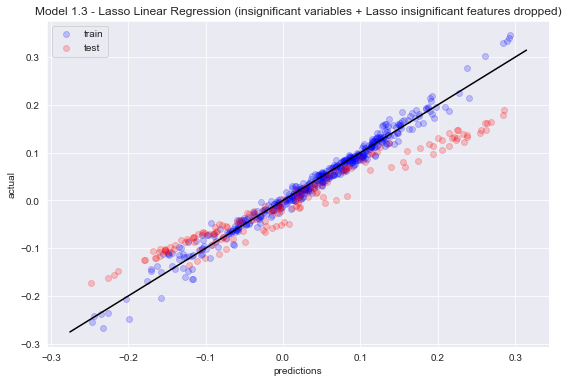

In [312]:
#Taking half of the top features
featurenamestodrop = feature_df.index.tolist()[(int(len(feature_df.index.tolist())/2 + 1)):
                                                (int(len(feature_df.index.tolist()) + 1))]

featurenames = feature_df.index.tolist()[0:int(len(feature_df.index.tolist())/2)]
print('kept features \n' + str(featurenames))

print('dropped features \n' + str(featurenamestodrop))

#rerunning the old sets
independent_variables = APPL1.drop(['20d_future_close_pct'], axis = 1)
independent_variables_names = independent_variables.columns.values.tolist()

#Our dependent variables or targets
dependent_variable_name = ['20d_future_close_pct']
dependent_variable = APPL1[dependent_variable_name]

#new set with the dropped variables
finalreg_independent_variables = independent_variables.drop(independent_variables[featurenamestodrop],
                                                           axis = 1)

#Linear regression scikit learn:
#With new record set

regression_independent_variables = independent_variables
train_size = int(0.75*dependent_variable.shape[0])
train_regression_independent_variables = finalreg_independent_variables[:train_size]
train_regression_dependent_variables = dependent_variable[:train_size]
test_regression_independent_variables = finalreg_independent_variables[train_size:]
test_regression_dependent_variables = dependent_variable[train_size:]


#Fit the model
#Call the package
from sklearn.linear_model import LinearRegression
#Setting the model
linregfinal = Lasso(alpha = 0.001)
#Fit to the data
linregfinal.fit(train_regression_independent_variables, train_regression_dependent_variables)
#make our predictions on our train and test set
train_linregfinal_pred = linregfinal.predict(train_regression_independent_variables)
test_linregfinal_pred = linregfinal.predict(test_regression_independent_variables)
#Check the scores of the train and test model

train_linregfinal_score = linregfinal.score(train_regression_independent_variables, 
                                  train_regression_dependent_variables)
test_linregfinal_score = linregfinal.score(test_regression_independent_variables, 
                                  test_regression_dependent_variables)

print("model1 linear regression score (training data) (final variable list): \n" 
      + str(train_linregfinal_score))
print("model1 linear regression score (test data) (final variable list): \n" 
      + str(test_linregfinal_score))

#Finally plot the data
f, ax = plt.subplots(figsize=(9, 6))
plt.scatter(train_linregfinal_pred, train_regression_dependent_variables,
            alpha=0.2, color='b', label='train')

plt.scatter(test_linregfinal_pred, test_regression_dependent_variables, 
            alpha=0.2, color='r', label='test')

xmin, xmax = plt.xlim()
plt.plot(np.arange(xmin, xmax, 0.01), np.arange(xmin, xmax, 0.01), c='k')
plt.xlabel('predictions')
plt.ylabel('actual')
plt.legend()  # show the legend
plt.title('Model 1.3 - Lasso Linear Regression (insignificant variables + Lasso insignificant features dropped)')
plt.show()

much better than the original model

Model 3 KNN

In [265]:
#Going to start again - entire dataset

#need to put in the logistic factor
#going to use 0 - ie if return <= 0 -> 0, if return > 0 -> 1 

independent_variables = APPL1.drop(['20d_future_close_pct'], axis = 1)
independent_variables_names = independent_variables.columns.values.tolist()

APPL1['negative_positive_20d_return'] = APPL1['20d_future_close_pct'].apply(lambda x:
                                                                           False if x <= 0 else True)

#drop this from the independent
classification_independent_variables = APPL1.drop(['negative_positive_20d_return'], axis = 1)
classification_independent_variables_names = independent_variables.columns.values.tolist()

classification_dependent_variable_name = ['negative_positive_20d_return']
classification_dependent_variable = APPL1[classification_dependent_variable_name]

print(APPL1['negative_positive_20d_return'].value_counts().sort_index())

#print(classification_dependent_variable)
#print(independent_variables_names)

#Setting up the test and train sets

#regression_independent_variables = independent_variables
train_size = int(0.75*dependent_variable.shape[0])
train_independent_variables = classification_independent_variables[:train_size]
train_dependent_variables = classification_dependent_variable[:train_size]
test_independent_variables = classification_independent_variables[train_size:]
test_dependent_variables = classification_dependent_variable[train_size:]
print(test_dependent_variables.value_counts().sort_index())

#Fit the model
#Call the package
from sklearn.neighbors import KNeighborsClassifier
#Setting the model
knn = KNeighborsClassifier(n_neighbors = 10)
#Fit to the data
knn.fit(train_independent_variables, train_dependent_variables)
#make our predictions on our train and test set
train_knn_pred = knn.predict(train_independent_variables)
test_knn_pred = knn.predict(test_independent_variables)
#Check the scores of the train and test model

train_knn_score = knn.score(train_independent_variables, 
                                  train_dependent_variables)
test_knn_score = knn.score(test_independent_variables, 
                                  test_dependent_variables)

print("model 3 K nearest neighbor score (training data) (10 neighbors): \n" + str(train_knn_score))
print("model 3 K nearest neighbor score (test data)(10 neighbors): \n" + str(test_knn_score))

#Finally plot the data
#from mlxtend.plotting import plot_decision_regions
#plot_decision_regions(test_independent_variables, test_dependent_variables, clf = knn)
#plt.show()

#print(knn.effective_metric_params_)


False    241
True     401
Name: negative_positive_20d_return, dtype: int64
negative_positive_20d_return
False                           93
True                            68
dtype: int64


C:\Users\Cathal Keating\Anaconda3\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


model 3 K nearest neighbor score (training data) (10 neighbors): 
0.9501039501039501
model 3 K nearest neighbor score (test data)(10 neighbors): 
0.577639751552795


In [ ]:
'''
# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = train_independent_variables[:, 0].min() - 1, train_independent_variables[:, 0].max() + 1
y_min, y_max = train_independent_variables[:, 1].min() - 1, train_independent_variables[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

# Plot also the training points
plt.scatter(train_independent_variables[:, 0], X[:, 1], c=y, cmap=cmap_bold)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
'''

Hyperparameter tuning and scaling

False    241
True     401
Name: negative_positive_20d_return, dtype: int64
negative_positive_20d_return
False                           93
True                            68
dtype: int64


C:\Users\Cathal Keating\Anaconda3\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\Cathal Keating\Anaconda3\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\Cathal Keating\Anaconda3\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\Cathal Keating\Anaconda3\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:207: DataConversionWarning: A column-vector y was

    neighbors     score
0           2  0.958420
1           4  0.956341
2           6  0.945946
3           8  0.943867
4          10  0.952183
5          12  0.931393
6          14  0.910603
7          16  0.916840
8          18  0.906445
9          20  0.898129
10         22  0.885655
11         24  0.881497
12         26  0.869023
13         28  0.871102
14         30  0.852391
15         32  0.841996
16         34  0.827443
17         36  0.798337
18         38  0.787942
19         40  0.781705
20         42  0.787942
21         44  0.779626
22         46  0.769231
23         48  0.767152
    neighbors     score
0           2  0.732919
1           4  0.714286
2           6  0.695652
3           8  0.695652
4          10  0.689441
5          12  0.683230
6          14  0.677019
7          16  0.670807
8          18  0.658385
9          20  0.645963
10         22  0.639752
11         24  0.602484
12         26  0.590062
13         28  0.583851
14         30  0.583851
15         32  0

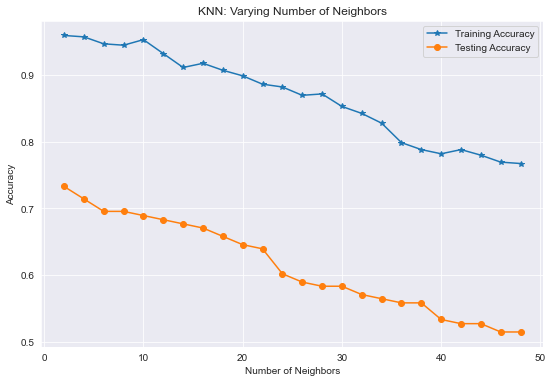

In [313]:
#Going to start again - entire dataset

#need to put in the logistic factor
#going to use 0 - ie if return <= 0 -> 0, if return > 0 -> 1 

independent_variables = APPL1.drop(['20d_future_close_pct'], axis = 1)
independent_variables_names = independent_variables.columns.values.tolist()

APPL1['negative_positive_20d_return'] = APPL1['20d_future_close_pct'].apply(lambda x:
                                                                           False if x <= 0 else True)

#drop this from the independent
classification_independent_variables = APPL1.drop(['negative_positive_20d_return'], axis = 1)
classification_independent_variables_names = independent_variables.columns.values.tolist()

classification_dependent_variable_name = ['negative_positive_20d_return']
classification_dependent_variable = APPL1[classification_dependent_variable_name]

print(APPL1['negative_positive_20d_return'].value_counts().sort_index())

#print(classification_dependent_variable)
#print(independent_variables_names)

#Setting up the test and train sets and scaling them

#regression_independent_variables = independent_variables
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

train_size = int(0.75*dependent_variable.shape[0])
train_independent_variables = sc.fit_transform(classification_independent_variables[:train_size])
train_dependent_variables = classification_dependent_variable[:train_size]
test_independent_variables = sc.fit_transform(classification_independent_variables[train_size:])
test_dependent_variables = classification_dependent_variable[train_size:]
print(test_dependent_variables.value_counts().sort_index())


#Fit the model
#Call the package
from sklearn.neighbors import KNeighborsClassifier


train_knntunescores = []
test_knntunescores = []
neighbors = range(2, 50, 2)

for neighbor in neighbors:
    
    knntune = KNeighborsClassifier(n_neighbors = neighbor)
    #Fit to the data
    knntune.fit(train_independent_variables, train_dependent_variables)
    #Setting the model
    knntune_pred = knntune.predict(test_independent_variables)
    train_knntunescores.append((neighbor, knntune.score(train_independent_variables, 
                                    train_dependent_variables)))
    test_knntunescores.append((neighbor, knntune.score(test_independent_variables, 
                                    test_dependent_variables)))
    

df_train_knntunescores = pd.DataFrame(train_knntunescores, columns=['neighbors', 'score'])
df_test_knntunescores = pd.DataFrame(test_knntunescores, columns=['neighbors', 'score'])

print(df_train_knntunescores)
print(df_test_knntunescores)

plt.figure(figsize=(9, 6))
plt.title("KNN: Varying Number of Neighbors")
plt.plot(neighbors, df_train_knntunescores['score'], label="Training Accuracy", marker = '*')
plt.plot(neighbors, df_test_knntunescores['score'], label="Testing Accuracy", marker = 'o')
plt.legend()
plt.xlabel("Number of Neighbors")
plt.ylabel("Accuracy")
plt.show()



2 seems to be the best
For the next section I will use the features predicted by t test of coefficents and feature selection in the regression example
I am going to continue scaling - this seems the best approach

In [330]:
#Taking half of the top features
featurenamestodrop = feature_df.index.tolist()[(int(len(feature_df.index.tolist())/2 + 1)):
                                                (int(len(feature_df.index.tolist()) + 1))]

featurenames = feature_df.index.tolist()[0:int(len(feature_df.index.tolist())/2)]
print('kept features \n' + str(featurenames))

print('dropped features \n' + str(featurenamestodrop))

#rerunning the old sets
independent_variables = APPL1.drop(['20d_future_close_pct'], axis = 1)
independent_variables_names = independent_variables.columns.values.tolist()

#Our dependent variables or targets
dependent_variable_name = ['20d_future_close_pct']
dependent_variable = APPL1[dependent_variable_name]

#new set with the dropped variables
finalreg_independent_variables = independent_variables.drop(independent_variables[featurenamestodrop],
                                                           axis = 1)

##########

dependent_variable['negative_positive_20d_return'] = dependent_variable['20d_future_close_pct'].apply(lambda x:
                                                                           False if x <= 0 else True)

finalreg_dependent_variable = dependent_variable.drop(['20d_future_close_pct'], axis = 1)

#print(finalreg_dependent_variable.columns)

#Linear regression scikit learn:
#With new record set

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

regression_independent_variables = independent_variables
train_size = int(0.75*dependent_variable.shape[0])
train_independent_variables = sc.fit_transform(finalreg_independent_variables[:train_size])
train_dependent_variables = finalreg_dependent_variable[:train_size]
test_independent_variables = sc.fit_transform(finalreg_independent_variables[train_size:])
test_dependent_variables = finalreg_dependent_variable[train_size:]

print(test_dependent_variables.value_counts().sort_index())

#Fit the model
#Call the package
from sklearn.neighbors import KNeighborsClassifier
#Setting the model
#6 was chosen from previous example
knn = KNeighborsClassifier(n_neighbors = 2)
#Fit to the data
knn.fit(train_independent_variables, train_dependent_variables)
#make our predictions on our train and test set
train_knn_pred = knn.predict(train_independent_variables)
test_knn_pred = knn.predict(test_independent_variables)
#Check the scores of the train and test model

train_knn_score = knn.score(train_independent_variables, 
                                  train_dependent_variables)
test_knn_score = knn.score(test_independent_variables, 
                                  test_dependent_variables)

print("model 2 K nearest neighbor score (training data) (2 neighbors): \n" + str(train_knn_score))
print("model 2 K nearest neighbor score (test data)(2 neighbors): \n" + str(test_knn_score))



kept features 
['Low']
dropped features 
[]
negative_positive_20d_return
False                           93
True                            68
dtype: int64


<ipython-input-330-2033a3019345>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dependent_variable['negative_positive_20d_return'] = dependent_variable['20d_future_close_pct'].apply(lambda x:
C:\Users\Cathal Keating\Anaconda3\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


model 2 K nearest neighbor score (training data) (2 neighbors): 
0.9958419958419958
model 2 K nearest neighbor score (test data)(2 neighbors): 
0.782608695652174


feature seletion + scaling + parameter tuning gives best answer of 0.77

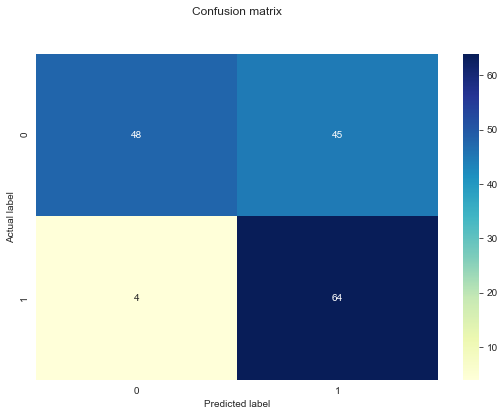

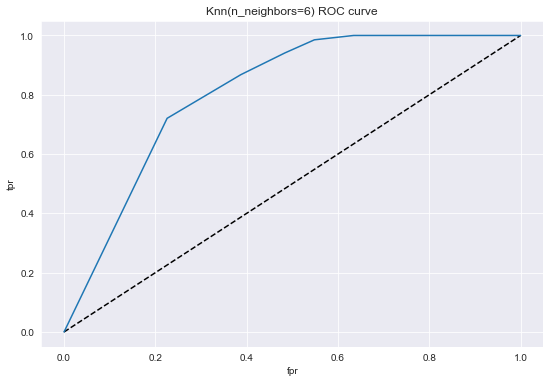

              precision    recall  f1-score   support

       False       0.92      0.52      0.66        93
        True       0.59      0.94      0.72        68

    accuracy                           0.70       161
   macro avg       0.76      0.73      0.69       161
weighted avg       0.78      0.70      0.69       161



In [317]:
#Looking at more graphical output for the optimmal KNN model

#1. Confusion Matrix
#import confusion_matrix
from sklearn.metrics import confusion_matrix
#let us get the predictions using the classifier we had fit above
plt.figure(figsize=(9, 6))
cnfmatrix = confusion_matrix(test_dependent_variables,test_knn_pred)
p = sns.heatmap(pd.DataFrame(cnfmatrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

#2. ROC - AUC
from sklearn.metrics import roc_curve
test_knn_pred_proba = knn.predict_proba(test_independent_variables)[:,1]
fpr, tpr, thresholds = roc_curve(test_dependent_variables, test_knn_pred_proba)
plt.figure(figsize=(9, 6))
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='Knn')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('Knn(n_neighbors=6) ROC curve')
plt.show()

#Looking at the accuracy:
#import classification_report
from sklearn.metrics import classification_report
print(classification_report(test_dependent_variables,test_knn_pred))

Model 4 Random Forest

In [150]:
#Going to start again - entire dataset

#need to put in the logistic factor
#going to use 0 - ie if return <= 0 -> 0, if return > 0 -> 1 

independent_variables = APPL1.drop(['20d_future_close_pct'], axis = 1)
independent_variables_names = independent_variables.columns.values.tolist()

APPL1['negative_positive_20d_return'] = APPL1['20d_future_close_pct'].apply(lambda x:
                                                                           False if x <= 0 else True)

#drop this from the independent
classification_independent_variables = APPL1.drop(['negative_positive_20d_return'], axis = 1)
classification_independent_variables_names = independent_variables.columns.values.tolist()

classification_dependent_variable_name = ['negative_positive_20d_return']
classification_dependent_variable = APPL1[classification_dependent_variable_name]

print(APPL1['negative_positive_20d_return'].value_counts().sort_index())

#print(classification_dependent_variable)
#print(independent_variables_names)

#Setting up the test and train sets

#regression_independent_variables = independent_variables
train_size = int(0.75*dependent_variable.shape[0])
train_independent_variables = classification_independent_variables[:train_size]
train_dependent_variables = classification_dependent_variable[:train_size]
test_independent_variables = classification_independent_variables[train_size:]
test_dependent_variables = classification_dependent_variable[train_size:]
print(test_dependent_variables.value_counts().sort_index())

#Fit the model
#Call the package
from sklearn.ensemble import RandomForestRegressor
#Setting the model
ranfor = RandomForestRegressor(n_estimators=200, max_depth=3, max_features = 5, random_state=42)
#Fit to the data
ranfor.fit(train_independent_variables, train_dependent_variables)
#make our predictions on our train and test set
train_ranfor_pred = ranfor.predict(train_independent_variables)
test_ranfor_pred = ranfor.predict(test_independent_variables)
#Check the scores of the train and test model

train_ranfor_score = ranfor.score(train_independent_variables, 
                                  train_dependent_variables)
test_ranfor_score = ranfor.score(test_independent_variables, 
                                  test_dependent_variables)

print("model 4 decision tree score (training data): \n" + str(train_ranfor_score))
print("model 4 decision tree score (test data): \n" + str(test_ranfor_score))

#need to find a better graph
'''
#Finally plot the data
plt.scatter(train_ranfor_pred, train_dependent_variables,
            alpha=0.2, color='b', label='train')

plt.scatter(test_ranfor_pred, test_dependent_variables, 
            alpha=0.2, color='r', label='test')

xmin, xmax = plt.xlim()
plt.plot(np.arange(xmin, xmax, 0.01), np.arange(xmin, xmax, 0.01), c='k')

plt.xlabel('predictions')
plt.ylabel('actual')
plt.legend()  # show the legend

plt.show()
'''

False    240
True     401
Name: negative_positive_20d_return, dtype: int64
negative_positive_20d_return
False                           93
True                            68
dtype: int64


<ipython-input-150-93fdaa54823b>:40: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  ranfor.fit(train_independent_variables, train_dependent_variables)


model 4 decision tree score (training data): 
0.7588807935452273
model 4 decision tree score (test data): 
0.4021707133748339


"\n#Finally plot the data\nplt.scatter(train_ranfor_pred, train_dependent_variables,\n            alpha=0.2, color='b', label='train')\n\nplt.scatter(test_ranfor_pred, test_dependent_variables, \n            alpha=0.2, color='r', label='test')\n\nxmin, xmax = plt.xlim()\nplt.plot(np.arange(xmin, xmax, 0.01), np.arange(xmin, xmax, 0.01), c='k')\n\nplt.xlabel('predictions')\nplt.ylabel('actual')\nplt.legend()  # show the legend\n\nplt.show()\n"

Hyperparameter tuning and scaling

In [151]:
#Going to start again - entire dataset

#need to put in the logistic factor
#going to use 0 - ie if return <= 0 -> 0, if return > 0 -> 1 

independent_variables = APPL1.drop(['20d_future_close_pct'], axis = 1)
independent_variables_names = independent_variables.columns.values.tolist()

APPL1['negative_positive_20d_return'] = APPL1['20d_future_close_pct'].apply(lambda x:
                                                                           False if x <= 0 else True)

#drop this from the independent
classification_independent_variables = APPL1.drop(['negative_positive_20d_return'], axis = 1)
classification_independent_variables_names = independent_variables.columns.values.tolist()

classification_dependent_variable_name = ['negative_positive_20d_return']
classification_dependent_variable = APPL1[classification_dependent_variable_name]

print(APPL1['negative_positive_20d_return'].value_counts().sort_index())

#Setting up the test and train sets

#regression_independent_variables = independent_variables
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

train_size = int(0.75*dependent_variable.shape[0])
train_independent_variables = sc.fit_transform(classification_independent_variables[:train_size])
train_dependent_variables = classification_dependent_variable[:train_size]
test_independent_variables = sc.fit_transform(classification_independent_variables[train_size:])
test_dependent_variables = classification_dependent_variable[train_size:]
print(test_dependent_variables.value_counts().sort_index())

#parameter tuning

param_grid = {'n_estimators' : [200, 300, 400, 500, 600, 800], 
              'max_depth' : [1, 2, 4], 
              'max_features' : [4, 5, 6, 7], 
              'random_state' : [42]
            #'criterion' : ['gini', 'entropy']}
             }

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
#Setting the model
ranfortuned = RandomForestRegressor()
#Fit to the data
#ranfortuned.fit(train_regression_independent_variables, train_regression_dependent_variables)

grid_ranfortuned = GridSearchCV(estimator = ranfortuned, param_grid = param_grid)

grid_ranfortuned.fit(train_independent_variables, train_dependent_variables)

print(grid_ranfortuned.best_params_)

False    240
True     401
Name: negative_positive_20d_return, dtype: int64
negative_positive_20d_return
False                           93
True                            68
dtype: int64


C:\Users\Cathal Keating\Anaconda3\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Cathal Keating\Anaconda3\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Cathal Keating\Anaconda3\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Cathal Keating\Anaconda3\Anaconda3\lib\site-packages\sklearn\mod

C:\Users\Cathal Keating\Anaconda3\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Cathal Keating\Anaconda3\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Cathal Keating\Anaconda3\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Cathal Keating\Anaconda3\Anaconda3\lib\site-packages\sklearn\mod

C:\Users\Cathal Keating\Anaconda3\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Cathal Keating\Anaconda3\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Cathal Keating\Anaconda3\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Cathal Keating\Anaconda3\Anaconda3\lib\site-packages\sklearn\mod

C:\Users\Cathal Keating\Anaconda3\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Cathal Keating\Anaconda3\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Cathal Keating\Anaconda3\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Cathal Keating\Anaconda3\Anaconda3\lib\site-packages\sklearn\mod

C:\Users\Cathal Keating\Anaconda3\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Cathal Keating\Anaconda3\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Cathal Keating\Anaconda3\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Cathal Keating\Anaconda3\Anaconda3\lib\site-packages\sklearn\mod

C:\Users\Cathal Keating\Anaconda3\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Cathal Keating\Anaconda3\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Cathal Keating\Anaconda3\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Cathal Keating\Anaconda3\Anaconda3\lib\site-packages\sklearn\mod

C:\Users\Cathal Keating\Anaconda3\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Cathal Keating\Anaconda3\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Cathal Keating\Anaconda3\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Cathal Keating\Anaconda3\Anaconda3\lib\site-packages\sklearn\mod

C:\Users\Cathal Keating\Anaconda3\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Cathal Keating\Anaconda3\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Cathal Keating\Anaconda3\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Cathal Keating\Anaconda3\Anaconda3\lib\site-packages\sklearn\mod

C:\Users\Cathal Keating\Anaconda3\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Cathal Keating\Anaconda3\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Cathal Keating\Anaconda3\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Cathal Keating\Anaconda3\Anaconda3\lib\site-packages\sklearn\mod

C:\Users\Cathal Keating\Anaconda3\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Cathal Keating\Anaconda3\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Cathal Keating\Anaconda3\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Cathal Keating\Anaconda3\Anaconda3\lib\site-packages\sklearn\mod

C:\Users\Cathal Keating\Anaconda3\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Cathal Keating\Anaconda3\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Cathal Keating\Anaconda3\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Cathal Keating\Anaconda3\Anaconda3\lib\site-packages\sklearn\mod

C:\Users\Cathal Keating\Anaconda3\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Cathal Keating\Anaconda3\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Cathal Keating\Anaconda3\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Cathal Keating\Anaconda3\Anaconda3\lib\site-packages\sklearn\mod

C:\Users\Cathal Keating\Anaconda3\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Cathal Keating\Anaconda3\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Cathal Keating\Anaconda3\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Cathal Keating\Anaconda3\Anaconda3\lib\site-packages\sklearn\mod

C:\Users\Cathal Keating\Anaconda3\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Cathal Keating\Anaconda3\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Cathal Keating\Anaconda3\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\Cathal Keating\Anaconda3\Anaconda3\lib\site-packages\sklearn\mod

{'max_depth': 4, 'max_features': 7, 'n_estimators': 200, 'random_state': 42}


Fit and test best model
Parameters
max_features 7
n_estimators 200
max_depth 4
scaled data

In [152]:
#Going to start again - entire dataset

#need to put in the logistic factor
#going to use 0 - ie if return <= 0 -> 0, if return > 0 -> 1 

independent_variables = APPL1.drop(['20d_future_close_pct'], axis = 1)
independent_variables_names = independent_variables.columns.values.tolist()

APPL1['negative_positive_20d_return'] = APPL1['20d_future_close_pct'].apply(lambda x:
                                                                           False if x <= 0 else True)

#drop this from the independent
classification_independent_variables = APPL1.drop(['negative_positive_20d_return'], axis = 1)
classification_independent_variables_names = independent_variables.columns.values.tolist()

classification_dependent_variable_name = ['negative_positive_20d_return']
classification_dependent_variable = APPL1[classification_dependent_variable_name]

print(APPL1['negative_positive_20d_return'].value_counts().sort_index())

#Setting up the test and train sets

#regression_independent_variables = independent_variables
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

train_size = int(0.75*dependent_variable.shape[0])
train_independent_variables = sc.fit_transform(classification_independent_variables[:train_size])
train_dependent_variables = classification_dependent_variable[:train_size]
test_independent_variables = sc.fit_transform(classification_independent_variables[train_size:])
test_dependent_variables = classification_dependent_variable[train_size:]
print(test_dependent_variables.value_counts().sort_index())

from sklearn.ensemble import RandomForestRegressor
#Setting the model
tuneranfor = RandomForestRegressor(n_estimators=200, max_depth=4, max_features=7, random_state=42)
#ranfor = RandomForestRegressor(n_estimators=500, max_depth=3, max_features=4, random_state=42)
#Fit to the data
tuneranfor.fit(train_independent_variables, train_dependent_variables)
#make our predictions on our train and test set
train_tuneranfor_pred = tuneranfor.predict(train_independent_variables)
test_tuneranfor_pred = tuneranfor.predict(test_independent_variables)
#Check the scores of the train and test model

train_tuneranfor_score = tuneranfor.score(train_independent_variables, 
                                  train_dependent_variables)
test_tuneranfor_score = tuneranfor.score(test_independent_variables, 
                                  test_dependent_variables)

print("model 5 decision tree score (training data)(tuned parameters scaled data): \n" 
      + str(train_tuneranfor_score))
print("model 5 decision tree score (test data)(tuned parameters scaled data): \n" 
      + str(test_tuneranfor_score))

False    240
True     401
Name: negative_positive_20d_return, dtype: int64
negative_positive_20d_return
False                           93
True                            68
dtype: int64


<ipython-input-152-4fc64281e435>:39: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  tuneranfor.fit(train_independent_variables, train_dependent_variables)


model 5 decision tree score (training data)(tuned parameters scaled data): 
0.9091550210641846
model 5 decision tree score (test data)(tuned parameters scaled data): 
0.3334858120642291


scaling doesn't seem to be a big deal going to remove

In [332]:
#Going to start again - entire dataset

#need to put in the logistic factor
#going to use 0 - ie if return <= 0 -> 0, if return > 0 -> 1 

independent_variables = APPL1.drop(['20d_future_close_pct'], axis = 1)
independent_variables_names = independent_variables.columns.values.tolist()

APPL1['negative_positive_20d_return'] = APPL1['20d_future_close_pct'].apply(lambda x:
                                                                           False if x <= 0 else True)

#drop this from the independent
classification_independent_variables = APPL1.drop(['negative_positive_20d_return'], axis = 1)
classification_independent_variables_names = independent_variables.columns.values.tolist()

classification_dependent_variable_name = ['negative_positive_20d_return']
classification_dependent_variable = APPL1[classification_dependent_variable_name]

print(APPL1['negative_positive_20d_return'].value_counts().sort_index())

#Setting up the test and train sets

#regression_independent_variables = independent_variables


train_size = int(0.75*dependent_variable.shape[0])
train_independent_variables = classification_independent_variables[:train_size]
train_dependent_variables = classification_dependent_variable[:train_size]
test_independent_variables = classification_independent_variables[train_size:]
test_dependent_variables = classification_dependent_variable[train_size:]
print(test_dependent_variables.value_counts().sort_index())

from sklearn.ensemble import RandomForestRegressor
#Setting the model
tuneranfor = RandomForestRegressor(n_estimators=200, max_depth=4, max_features=7, random_state=42)
#ranfor = RandomForestRegressor(n_estimators=500, max_depth=3, max_features=4, random_state=42)
#Fit to the data
tuneranfor.fit(train_independent_variables, train_dependent_variables)
#make our predictions on our train and test set
train_tuneranfor_pred = tuneranfor.predict(train_independent_variables)
test_tuneranfor_pred = tuneranfor.predict(test_independent_variables)
#Check the scores of the train and test model

train_tuneranfor_score = tuneranfor.score(train_independent_variables, 
                                  train_dependent_variables)
test_tuneranfor_score = tuneranfor.score(test_independent_variables, 
                                  test_dependent_variables)

print("model 5 decision tree score (training data)(tuned parameters): \n" 
      + str(train_tuneranfor_score))
print("model 5 decision tree score (test data)(tuned parameters): \n" 
      + str(test_tuneranfor_score))

print(train_independent_variables.columns, tuneranfor.feature_importances_)

False    241
True     401
Name: negative_positive_20d_return, dtype: int64
negative_positive_20d_return
False                           93
True                            68
dtype: int64


<ipython-input-332-5b640206a17f>:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  tuneranfor.fit(train_independent_variables, train_dependent_variables)


model 5 decision tree score (training data)(tuned parameters): 
0.9107772528281385
model 5 decision tree score (test data)(tuned parameters): 
0.6284367293228207
Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', '20d_close_pct',
       '20d_future_close', '20d_future_close_pct', 'adx', 'adxr', 'aroon',
       'bop', 'cci', 'cmo', 'dx', 'minus_di', 'minus_dm', 'mom', 'plus_di',
       'plus_dm', 'ppo', 'rocp', 'rsi', 'slowk', 'slowd', 'fastk', 'fastd',
       'fastkrsi', 'fastdrsi', 'trix', 'ultosc', 'willr', 'macd',
       'macd_signal', 'macd_hist', 'ad', 'adosc', 'obv', 'roc', 'ht_dcphase',
       'ht_trendmode', 'dema', 'kama', 'sar', 'sma', 'tema', 'trima', 'wma'],
      dtype='object') [1.09430026e-02 9.31617412e-03 1.19619851e-02 1.42182112e-02
 8.45019095e-03 5.07999947e-04 9.37077679e-04 2.53412033e-02
 3.78955316e-01 2.87319013e-02 1.80351865e-03 1.78526583e-02
 3.59290383e-05 6.83495927e-03 1.21952666e-02 1.24228690e-02
 3.61930578e-02 2.42846970e-02 3.23215728e-0

For the next section I will use random forest feature importances to reduce the variable list

<ipython-input-333-2c3b9cb906af>:35: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  tuneranfor.fit(train_independent_variables, train_dependent_variables)


49
                      coefficent
20d_future_close_pct    0.378955
plus_dm                 0.068975
plus_di                 0.036629
minus_di                0.036193
mom                     0.032322
ad                      0.029661
adx                     0.028732
trix                    0.028290
sma                     0.025886
20d_future_close        0.025341
minus_dm                0.024285
macd_signal             0.020616
trima                   0.020588
rocp                    0.019061
wma                     0.018687
aroon                   0.017853
Close                   0.014218
obv                     0.014147
roc                     0.013596
dx                      0.012423
rsi                     0.012338
cmo                     0.012195
Low                     0.011962
Open                    0.010943
tema                    0.010683
macd                    0.009608
High                    0.009316
Adj Close               0.008450
cci                     0.006835
kama   

<function matplotlib.pyplot.show(close=None, block=None)>

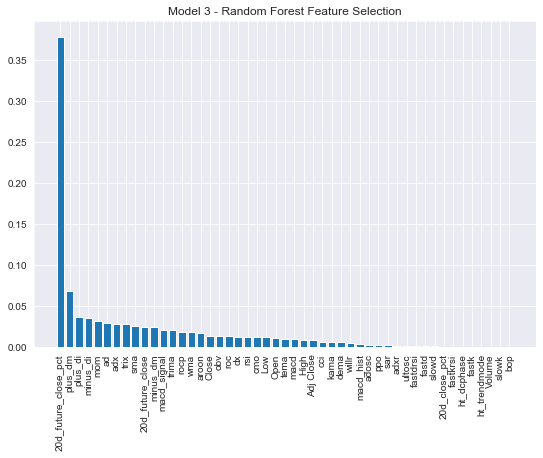

In [333]:
#Going to start again - entire dataset

#need to put in the logistic factor
#going to use 0 - ie if return <= 0 -> 0, if return > 0 -> 1 

independent_variables = APPL1.drop(['20d_future_close_pct'], axis = 1)
independent_variables_names = independent_variables.columns.values.tolist()

APPL1['negative_positive_20d_return'] = APPL1['20d_future_close_pct'].apply(lambda x:
                                                                           False if x <= 0 else True)

#drop this from the independent
classification_independent_variables = APPL1.drop(['negative_positive_20d_return'], axis = 1)
classification_independent_variables_names = independent_variables.columns.values.tolist()

classification_dependent_variable_name = ['negative_positive_20d_return']
classification_dependent_variable = APPL1[classification_dependent_variable_name]

#print(APPL1['negative_positive_20d_return'].value_counts().sort_index())

#Setting up the test and train sets

train_size = int(0.75*dependent_variable.shape[0])
train_independent_variables = classification_independent_variables[:train_size]
train_dependent_variables = classification_dependent_variable[:train_size]
test_independent_variables = classification_independent_variables[train_size:]
test_dependent_variables = classification_dependent_variable[train_size:]
#print(test_dependent_variables.value_counts().sort_index())

from sklearn.ensemble import RandomForestRegressor
#Setting the model
tuneranfor = RandomForestRegressor(n_estimators=200, max_depth=4, max_features=7, random_state=42)
#ranfor = RandomForestRegressor(n_estimators=500, max_depth=3, max_features=4, random_state=42)
#Fit to the data
tuneranfor.fit(train_independent_variables, train_dependent_variables)
#make our predictions on our train and test set
train_tuneranfor_pred = tuneranfor.predict(train_independent_variables)
test_tuneranfor_pred = tuneranfor.predict(test_independent_variables)
#Check the scores of the train and test model

train_tuneranfor_score = tuneranfor.score(train_independent_variables, 
                                  train_dependent_variables)
test_tuneranfor_score = tuneranfor.score(test_independent_variables, 
                                  test_dependent_variables)


#print(train_independent_variables.columns, tuneranfor.feature_importances_)

#storing the absolte value of the feature importances
tuneranfor_coef = abs(tuneranfor.feature_importances_)

#creating the dictionary of the features and the feature importances
ranforfeature_dict = dict(zip(train_independent_variables.columns, tuneranfor_coef))

#create a pd dataframe of the features
ranforfeature_df = pd.DataFrame.from_dict(ranforfeature_dict, orient = 'index')
ranforfeature_df.columns = ['coefficent']
#Sort the data
ranforfeature_df.sort_values(by = ['coefficent'], inplace = True, ascending = False)

print(len(ranforfeature_df))
#print(49/3)
print(ranforfeature_df)

f, ax = plt.subplots(figsize=(9, 6))
plt.bar(ranforfeature_df.index, ranforfeature_df['coefficent'])
plt.xticks(rotation = 90)
plt.title('Model 3 - Random Forest Feature Selection')

plt.show


In [ ]:
#will fit to half the dataset so 25

In [336]:
#Taking half of the top features
featurenamestodrop = ranforfeature_df.index.tolist()[(int(math.ceil(len(ranforfeature_df.index.tolist())/2 + 1))):
                                                (int(len(ranforfeature_df.index.tolist()) + 1))]

featurenames = ranforfeature_df.index.tolist()[0:(int(math.ceil(len(ranforfeature_df.index.tolist())/2 + 1)))]
print('kept features \n' + str(featurenames))

print('dropped features \n' + str(featurenamestodrop))

#rerunning the old sets
independent_variables = APPL1.drop(['20d_future_close_pct'], axis = 1)
independent_variables_names = independent_variables.columns.values.tolist()

#Our dependent variables or targets
dependent_variable_name = ['20d_future_close_pct']
dependent_variable = APPL1[dependent_variable_name]

#new set with the dropped variables
finalreg_independent_variables = independent_variables.drop(independent_variables[featurenamestodrop],
                                                           axis = 1)


dependent_variable['negative_positive_20d_return'] = dependent_variable['20d_future_close_pct'].apply(lambda x:
                                                                           False if x <= 0 else True)

finalreg_dependent_variable = dependent_variable.drop(['20d_future_close_pct'], axis = 1)

#import model package
from sklearn.ensemble import RandomForestRegressor
#Setting the model
featuretuneranfor = RandomForestRegressor(n_estimators=200, max_depth=4, 
                                          max_features=7, random_state=42)
#ranfor = RandomForestRegressor(n_estimators=500, max_depth=3, max_features=4, random_state=42)
#Fit to the data
featuretuneranfor.fit(train_independent_variables, train_dependent_variables)
#make our predictions on our train and test set
train_featuretuneranfor_pred = featuretuneranfor.predict(train_independent_variables)
test_featuretuneranfor_pred = featuretuneranfor.predict(test_independent_variables)
#Check the scores of the train and test model

train_featuretuneranfor_score = featuretuneranfor.score(train_independent_variables, 
                                                        train_dependent_variables)
test_featuretuneranfor_score = featuretuneranfor.score(test_independent_variables, 
                                                       test_dependent_variables)

print("model 5 decision tree score (training data)(tuned parameters / feature selection): \n" 
      + str(train_featuretuneranfor_score))
print("model 5 decision tree score (test data)(tuned parameters / feature selection): \n" 
      + str(test_featuretuneranfor_score))

kept features 
['20d_future_close_pct', 'plus_dm', 'plus_di', 'minus_di', 'mom', 'ad', 'adx', 'trix', 'sma', '20d_future_close', 'minus_dm', 'macd_signal', 'trima', 'rocp', 'wma', 'aroon', 'Close', 'obv', 'roc', 'dx', 'rsi', 'cmo', 'Low', 'Open', 'tema', 'macd']
dropped features 
['High', 'Adj Close', 'cci', 'kama', 'dema', 'willr', 'macd_hist', 'adosc', 'ppo', 'sar', 'adxr', 'ultosc', 'fastdrsi', 'fastd', 'slowd', '20d_close_pct', 'fastkrsi', 'ht_dcphase', 'fastk', 'ht_trendmode', 'Volume', 'slowk', 'bop']


<ipython-input-336-98aba105cf0c>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dependent_variable['negative_positive_20d_return'] = dependent_variable['20d_future_close_pct'].apply(lambda x:
<ipython-input-336-98aba105cf0c>:35: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  featuretuneranfor.fit(train_independent_variables, train_dependent_variables)


model 5 decision tree score (training data)(tuned parameters / feature selection): 
0.9107772528281385
model 5 decision tree score (test data)(tuned parameters / feature selection): 
0.6284367293228207


In [335]:
#Looking at more graphical output for the optimmal random forest model

#1. Confusion Matrix
#import confusion_matrix
from sklearn.metrics import confusion_matrix
#let us get the predictions using the classifier we had fit above
cnfmatrix = confusion_matrix(test_dependent_variables,test_featuretuneranfor_pred)
p = sns.heatmap(pd.DataFrame(cnfmatrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()
'''
#2. ROC - AUC
from sklearn.metrics import roc_curve
test_featuretuneranfor_pred_proba = featuretuneranfor.predict_proba(test_independent_variables)[:,1]
fpr, tpr, thresholds = roc_curve(test_dependent_variables, test_featuretuneranfor_pred_proba)

plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='Knn')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('Knn(n_neighbors=6) ROC curve')
plt.show()

#Looking at the accuracy:
#import classification_report
from sklearn.metrics import classification_report
print(classification_report(test_dependent_variables,test_featuretuneranfor_pred))
'''

ValueError: Classification metrics can't handle a mix of binary and continuous targets

RegEX example

In [1]:
#I didnt have the need to do regex in teh project so  here is an example

# Python program to validate an Email

# import re module

# re module provides support
# for regular expressions
import re

# Make a regular expression
# for validating an Email
regex = r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b'

# Define a function for
# for validating an Email

def check(email):
    # pass the regular expression
    # and the string into the fullmatch() method
    if(re.fullmatch(regex, email)):
        print("Valid Email")
    else:
        print("Invalid Email")


#examples:

email1 = 'cathalkeating@yahoo.com'
email2 = 'cathalkeating.com'
email3 = 'hello world'

check(email1)
check(email2)
check(email3)

Valid Email
Invalid Email
Invalid Email
